# Setup

In [ ]:
#@title  { vertical-output: true, display-mode: "both" }
!pip install -q ase
!pip install -q torch==1.8.0
!pip install  torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git@1.7.0

     |████████████████████████████████| 2.2MB 4.0MB/s 
     |████████████████████████████████| 735.5MB 23kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.8.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.8.0 which is incompatible.
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
     |████████████████████████████████| 2.7MB 312kB/s 
     |████████████████████████████████| 1.5MB 222kB/s 
     |████████████████████████████████| 1.1MB 3.9MB/s 
     |████████████████████████████████| 399kB 306kB/s 
     |████████████████████████████████| 235kB 4.2MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 


In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import ase
from pprint import pprint
from torch_geometric.data import DataLoader

In [ ]:
# use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
DTYPE = torch.float64
ff = torch.tensor(54, dtype=DTYPE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path2data = '/content/drive/My Drive/Colab Notebooks/pytorch geometric/input/'

Mounted at /content/drive


# pbc_edges

In [ ]:
#@title  { vertical-output: true, form-width: "25%" }
from torch_geometric.nn import DimeNet
from torch_geometric.nn.acts import swish
from math import sqrt, pi as PI

import numpy as np
import torch
from torch.nn import Linear, Embedding
from torch_scatter import scatter
from torch_sparse import SparseTensor
from torch_geometric.nn import radius_graph
from torch_geometric.data import download_url
from torch_geometric.data.makedirs import makedirs

from torch_geometric.nn.models.dimenet import Envelope
from torch_geometric.nn.models.dimenet import BesselBasisLayer
from torch_geometric.nn.models.dimenet import SphericalBasisLayer
from torch_geometric.nn.models.dimenet import ResidualLayer
from torch_geometric.nn.models.dimenet import InteractionBlock
from torch_geometric.nn.models.dimenet import OutputBlock

from torch_geometric.nn.models.dimenet_utils import bessel_basis, real_sph_harm
import ase
from ase.neighborlist import neighbor_list 
from ase import Atoms

from torch_geometric.data import DataLoader

try:
    import sympy as sym
except ImportError:
    sym = None

import os
try:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
except ImportError:
    tf = None

# TODO: move this somewhere else
device = DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.float64


def pbc_edges(cutoff, z, x, cell, batch, compute_sc=False):

  NH1 = torch.tensor([], dtype=torch.long, device=DEVICE)
  NH2 = torch.tensor([], dtype=torch.long, device=DEVICE)
  S = torch.tensor([], dtype=torch.long, device=DEVICE)
  D = torch.tensor([], dtype=DTYPE, device=DEVICE)
  SC = torch.tensor([], dtype=DTYPE, device=DEVICE) if compute_sc else None
  x_ = torch.clone(x).detach().cpu().numpy()

  if batch is not None:
    # count number of elements for each batch
    batch_ids = list(set(batch.cpu().tolist()))
    batch_sizes = [ (batch == id).sum().item() for id in batch_ids ]

    for i in range(len(batch_sizes)):
      offset = sum(batch_sizes[:i]) # to obtain correct atom indices
      
      atoms = Atoms(charges = (z[offset:offset + batch_sizes[i]]).cpu(), 
        positions = x_[offset:offset + batch_sizes[i]], 
        cell = (cell[3*i:3*(i+1)]).cpu(),
        pbc=True
      ) 
      
      nh1, nh2, s = neighbor_list("ijS", atoms, cutoff, self_interaction=False) 
      nh1 = torch.tensor(nh1, dtype=torch.long, device=DEVICE)
      nh2 = torch.tensor(nh2, dtype=torch.long, device=DEVICE)
      nh1 = nh1 + offset
      nh2 = nh2 + offset
      s = torch.tensor(s, dtype=DTYPE, device=DEVICE)
      d = x[nh2] - x[nh1] + torch.matmul(s, cell[3*i:3*(i+1)])
      
      if compute_sc:
        cell_flat = torch.flatten(cell[3*i:3*(i+1)])
        sc = torch.tile(cell_flat, (len(d), 1))
        sc[:, 0:3] = (sc[:, 0:3].T * s[:, 0]).T
        sc[:, 3:6] = (sc[:, 3:6].T * s[:, 1]).T
        sc[:, 6:9] = (sc[:, 6:9].T * s[:, 2]).T
        SC = torch.cat((SC, sc), 0)      

      NH1 = torch.cat((NH1, nh1), 0)
      NH2 = torch.cat((NH2, nh2), 0)
      S = torch.cat((S, s), 0)
      D = torch.cat((D, d), 0)

  else: # no batch
    atoms = Atoms(charges = z.cpu(), positions = x.detach().numpy(), cell = cell.cpu(), pbc=True)
    nh1, nh2, s = neighbor_list("ijS", atoms, cutoff, self_interaction=False)
    nh1 = torch.tensor(nh1, dtype=torch.long, device=DEVICE)
    nh2 = torch.tensor(nh2, dtype=torch.long, device=DEVICE)
    s = torch.tensor(s, dtype=DTYPE, device=DEVICE)
    d = x[nh2] - x[nh1] + torch.matmul(s, cell)
    
    if compute_sc:
      cell_flat = torch.flatten(cell)
      sc = torch.tile(cell_flat, (len(d), 1))
      sc[:, 0:3] = (sc[:, 0:3].T * s[:, 0]).T
      sc[:, 3:6] = (sc[:, 3:6].T * s[:, 1]).T
      sc[:, 6:9] = (sc[:, 6:9].T * s[:, 2]).T  
      SC = sc

    NH1, NH2, S, D = nh1, nh2, s, d

  D = D.norm(dim=-1)
  return  NH1, NH2, D, S, SC 

# SchNet

In [ ]:
import os
import warnings
import os.path as osp
from math import pi as PI

import ase
import torch
import torch.nn.functional as F
from torch.nn import Embedding, Sequential, Linear, ModuleList
import numpy as np

from torch_scatter import scatter
from torch_geometric.data.makedirs import makedirs
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn import radius_graph, MessagePassing


class MySchNet(torch.nn.Module):

    def __init__(self, hidden_channels=128, num_filters=128,
                 num_interactions=6, num_gaussians=50, cutoff=10.0,
                 readout='add', dipole=False, mean=None, std=None,
                 atomref=None, pbcs=False):
        super(MySchNet, self).__init__()

        assert readout in ['add', 'sum', 'mean']
        assert pbcs in [True, False]

        self.hidden_channels = hidden_channels
        self.num_filters = num_filters
        self.num_interactions = num_interactions
        self.num_gaussians = num_gaussians
        self.cutoff = cutoff
        self.readout = readout
        self.dipole = dipole
        self.readout = 'add' if self.dipole else self.readout
        self.mean = mean
        self.std = std
        self.scale = None

        atomic_mass = torch.from_numpy(ase.data.atomic_masses)
        self.register_buffer('atomic_mass', atomic_mass)

        self.embedding = Embedding(100, hidden_channels)
        self.distance_expansion = GaussianSmearing(0.0, cutoff, num_gaussians)

        self.interactions = ModuleList()
        for _ in range(num_interactions):
            block = InteractionBlock(hidden_channels, num_gaussians,
                                     num_filters, cutoff)
            self.interactions.append(block)

        self.lin1 = Linear(hidden_channels, hidden_channels // 2)
        self.act = ShiftedSoftplus()
        self.lin2 = Linear(hidden_channels // 2, 1)

        self.register_buffer('initial_atomref', atomref)
        self.atomref = None
        if atomref is not None:
            self.atomref = Embedding(100, 1)
            self.atomref.weight.data.copy_(atomref)

        self.pbcs = pbcs
        
        self.reset_parameters()

    def reset_parameters(self):
        self.embedding.reset_parameters()
        for interaction in self.interactions:
            interaction.reset_parameters()
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        self.lin1.bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0)
        if self.atomref is not None:
            self.atomref.weight.data.copy_(self.initial_atomref)


    def forward(self, z, pos, cell, batch=None):
        assert z.dim() == 1 and z.dtype == torch.long
        batch = torch.zeros_like(z) if batch is None else batch

        h = self.embedding(z)        

        if self.pbcs:
          row, col, edge_weight, _, _ = pbc_edges(self.cutoff, z, pos, cell, batch, compute_sc=False) 
          edge_index = torch.stack((row, col))
        else:
          edge_index = radius_graph(pos, r=self.cutoff, batch=batch)
          row, col = edge_index
          edge_weight = (pos[row] - pos[col]).norm(dim=-1)
        
        edge_attr = self.distance_expansion(edge_weight)

        for interaction in self.interactions:
            h = h + interaction(h, edge_index, edge_weight, edge_attr)

        h = self.lin1(h)
        h = self.act(h)
        h = self.lin2(h)

        if self.dipole:
            # Get center of mass.
            mass = self.atomic_mass[z].view(-1, 1)
            c = scatter(mass * pos, batch, dim=0) / scatter(mass, batch, dim=0)
            h = h * (pos - c[batch])

        if not self.dipole and self.mean is not None and self.std is not None:
            h = h * self.std + self.mean

        if not self.dipole and self.atomref is not None:
            h = h + self.atomref(z)

        out = scatter(h, batch, dim=0, reduce=self.readout)
        
        if self.dipole:
            out = torch.norm(out, dim=-1, keepdim=True)

        if self.scale is not None:
            out = self.scale * out

        return out


    def __repr__(self):
        return (f'{self.__class__.__name__}('
                f'hidden_channels={self.hidden_channels}, '
                f'num_filters={self.num_filters}, '
                f'num_interactions={self.num_interactions}, '
                f'num_gaussians={self.num_gaussians}, '
                f'cutoff={self.cutoff})')



class InteractionBlock(torch.nn.Module):
    def __init__(self, hidden_channels, num_gaussians, num_filters, cutoff):
        super(InteractionBlock, self).__init__()
        self.mlp = Sequential(
            Linear(num_gaussians, num_filters),
            ShiftedSoftplus(),
            Linear(num_filters, num_filters),
        )
        self.conv = CFConv(hidden_channels, hidden_channels, num_filters,
                           self.mlp, cutoff)
        self.act = ShiftedSoftplus()
        self.lin = Linear(hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.mlp[0].weight)
        self.mlp[0].bias.data.fill_(0)
        torch.nn.init.xavier_uniform_(self.mlp[2].weight)
        self.mlp[0].bias.data.fill_(0)
        self.conv.reset_parameters()
        torch.nn.init.xavier_uniform_(self.lin.weight)
        self.lin.bias.data.fill_(0)

    def forward(self, x, edge_index, edge_weight, edge_attr):
        x = self.conv(x, edge_index, edge_weight, edge_attr)
        x = self.act(x)
        x = self.lin(x)
        return x


class CFConv(MessagePassing):
    def __init__(self, in_channels, out_channels, num_filters, nn, cutoff):
        super(CFConv, self).__init__(aggr='add')
        self.lin1 = Linear(in_channels, num_filters, bias=False)
        self.lin2 = Linear(num_filters, out_channels)
        self.nn = nn
        self.cutoff = cutoff

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        torch.nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0)

    def forward(self, x, edge_index, edge_weight, edge_attr):
        C = 0.5 * (torch.cos(edge_weight * PI / self.cutoff) + 1.0)
        W = self.nn(edge_attr) * C.view(-1, 1)

        x = self.lin1(x)
        x = self.propagate(edge_index, x=x, W=W)
        x = self.lin2(x)
        return x

    def message(self, x_j, W):
        return x_j * W


class GaussianSmearing(torch.nn.Module):
    def __init__(self, start=0.0, stop=5.0, num_gaussians=50):
        super(GaussianSmearing, self).__init__()
        offset = torch.linspace(start, stop, num_gaussians)
        self.coeff = (-0.5 / (offset[1] - offset[0]).item()**2)
        self.register_buffer('offset', offset)

    def forward(self, dist):
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        res = torch.exp(self.coeff * torch.pow(dist, 2))
        return res

class ShiftedSoftplus(torch.nn.Module):
    def __init__(self):
        super(ShiftedSoftplus, self).__init__()
        self.shift = torch.log(torch.tensor(2.0)).item()

    def forward(self, x):
        return F.softplus(x) - self.shift

# DimeNetx

In [ ]:
class EmbeddingBlock(torch.nn.Module):
  def __init__(self, num_radial, hidden_channels, act=swish):
    super(EmbeddingBlock, self).__init__()
    self.act = act

    self.emb = Embedding(95, hidden_channels)
    self.lin_rbf = Linear(num_radial, hidden_channels, bias=False)
    self.lin = Linear(3 * hidden_channels, hidden_channels)

    self.reset_parameters()

  def reset_parameters(self):
    self.emb.weight.data.uniform_(-sqrt(3), sqrt(3))
    self.lin_rbf.reset_parameters()
    self.lin.reset_parameters()

  def forward(self, x, rbf, i, j):
    x = self.emb(x)
    #rbf = self.act(self.lin_rbf(rbf)) # FIX: this should not have an activation function
    rbf = self.lin_rbf(rbf)
    return self.act(self.lin(torch.cat([x[i], x[j], rbf], dim=-1)))



class DimeNetx(torch.nn.Module):
  
  def __init__(self, hidden_channels, out_channels, num_blocks, num_bilinear,
                 num_spherical, num_radial, cutoff=5.0, envelope_exponent=5,
                 num_before_skip=1, num_after_skip=2, num_output_layers=3,
                 act=swish, mean=None, std=None):
    super(DimeNetx, self).__init__()

    self.cutoff = cutoff

    #set mean and standard deviation of energies
    self.mean = mean 
    self.std = std

    # padding used for PBCs
    self.padding = torch.nn.ConstantPad2d((0,6,0,0), 0)

    if sym is None:
        raise ImportError('Package `sympy` could not be found.')

    self.num_blocks = num_blocks

    self.rbf = BesselBasisLayer(num_radial, cutoff, envelope_exponent)
    self.sbf = SphericalBasisLayer(num_spherical, num_radial, cutoff,
                                    envelope_exponent)

    self.emb = EmbeddingBlock(num_radial, hidden_channels, act)

    self.output_blocks = torch.nn.ModuleList([
        OutputBlock(num_radial, hidden_channels, out_channels,
                    num_output_layers, act) for _ in range(num_blocks + 1)
    ])

    self.interaction_blocks = torch.nn.ModuleList([
        InteractionBlock(hidden_channels, num_bilinear, num_spherical,
                          num_radial, num_before_skip, num_after_skip, act)
        for _ in range(num_blocks)
    ])

    self.reset_parameters()

  def reset_parameters(self):
    self.rbf.reset_parameters()
    self.emb.reset_parameters()
    for out in self.output_blocks:
      out.reset_parameters()
    for interaction in self.interaction_blocks:
      interaction.reset_parameters()

  def triplets_original(self, edge_index, num_nodes):
    row, col = edge_index  # j->i

    value = torch.arange(row.size(0), device=row.device)
    adj_t = SparseTensor(row=col, col=row, value=value,
                         sparse_sizes=(num_nodes, num_nodes))
    adj_t_row = adj_t[row]
    num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

    # Node indices (k->j->i) for triplets.
    idx_i = col.repeat_interleave(num_triplets)
    idx_j = row.repeat_interleave(num_triplets)
    idx_k = adj_t_row.storage.col()
    mask = (idx_i != idx_k)  # Remove i == k triplets.
    idx_i, idx_j, idx_k = idx_i[mask], idx_j[mask], idx_k[mask]

    # Edge indices (k-j, j->i) for triplets.
    idx_kj = adj_t_row.storage.value()[mask]
    idx_ji = adj_t_row.storage.row()[mask]

    return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji


  def triplets(self, edge_index, num_nodes, shift_cells=None, shift=None):
    row, col = edge_index  # j->i

    value = torch.arange(row.size(0), device=row.device)
    adj_t = SparseTensor(row=col, col=row, value=value,
                         sparse_sizes=(num_nodes, num_nodes))
    adj_t_row = adj_t[row]
    num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

    idx_i = col.repeat_interleave(num_triplets)
    idx_j = row.repeat_interleave(num_triplets)
    idx_k = adj_t_row.storage.col()

    if shift_cells is not None: # Update also the shift vectors
      shift_cells_i = shift_cells.repeat_interleave(num_triplets, dim=0)
      shift_i = shift.repeat_interleave(num_triplets, dim=0)
      shift_cells_k = -shift_cells[adj_t_row.storage.value()]
      shift_k = -shift[adj_t_row.storage.value()]

    mask = torch.all((torch.cat((torch.unsqueeze(idx_i, 1), shift_i), dim=1) ==\
                      torch.cat((torch.unsqueeze(idx_k, 1), shift_k), dim=1)), dim=1)

    idx_i, idx_j, idx_k = idx_i[~mask], idx_j[~mask], idx_k[~mask]
    if shift_cells is not None: # Remove also from the shift vector
      shift_cells_i = shift_cells_i[~mask]
      shift_cells_k = shift_cells_k[~mask]
      shift_i = shift_i[~mask]
      shift_k = shift_k[~mask]

    idx_kj = adj_t_row.storage.value()[~mask]
    idx_ji = adj_t_row.storage.row()[~mask]

    return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji, shift_cells_i, shift_i, shift_cells_k, shift_k


  def forward(self, z, pos, cell=None, batch=None):
        
    edge_index = []
    dist = []
    shift_cells = None
    if cell is not None: # implement PBC
      r1, r2, dist, shift, shift_cells = pbc_edges(self.cutoff, z, pos, cell, batch, compute_sc=True) 
      edge_index = [r1, r2]

        
      i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji, shift_cells_i, shift_i, shift_cells_k, shift_k = self.triplets(
          edge_index, num_nodes=z.size(0), shift_cells=shift_cells, shift=shift)        
    else: # old method without PBC
      edge_index = radius_graph(pos, r=self.cutoff, batch=batch)
      i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji = self.triplets_original(
          edge_index, num_nodes=z.size(0))        
      dist = (pos[i] - pos[j]).pow(2).sum(dim=-1).sqrt()

    # Define atoms position 
    pos_i = pos[idx_i]
    pos_j = pos[idx_j]
    pos_k = pos[idx_k]

    if cell is not None: # Fix coordinates for PBCs

      pos_i = pos_i + shift_cells_i[:, 0:3] + shift_cells_i[:, 3:6] + shift_cells_i[:, 6:9]
      pos_k = pos_k + shift_cells_k[:, 0:3] + shift_cells_k[:, 3:6] + shift_cells_k[:, 6:9]
      sc_ij = torch.all(~torch.all(pos_i == pos_j, dim=1)) 
      sc_kj = torch.all(~torch.all(pos_k == pos_j, dim=1))
      #if not (sc_ij and sc_kj):
      #   raise NameError('Found same position for different atoms!')

    # Calculate angles - with some Fixes to indexes compared to the orig. version
    pos_ji, pos_kj = pos_j - pos_i, pos_k - pos_j
    a = (pos_ji * pos_kj).sum(dim=-1)
    b = torch.cross(pos_ji, pos_kj).norm(dim=-1) 
    angle = torch.atan2(b, a)      

    rbf = self.rbf(dist)
    sbf = self.sbf(dist, angle, idx_kj)

    # Embedding block.
    x = self.emb(z, rbf, i, j)
    P = self.output_blocks[0](x, rbf, i, num_nodes=pos.size(0))

    # Interaction blocks.
    for interaction_block, output_block in zip(self.interaction_blocks,
                                               self.output_blocks[1:]):
      x = interaction_block(x, rbf, sbf, idx_kj, idx_ji)
      a = output_block(x, rbf, i, num_nodes=pos.size(0))
      P += a

    # Energy de-standardization
    if self.std is not None and self.mean is not None:
      P = P * self.std + self.mean

    res = P.sum(dim=0) if batch is None else scatter(P, batch, dim=0)
    return res

#DimeNet

# Helper functions

In [ ]:
def volume(coords):
  a = np.array(coords)
  a = a.reshape((3,3))
  return np.linalg.det(a)

In [ ]:
M_1_54 = None

from ase import build
def extend_atoms(atoms: ase.Atoms, target: int):
  global M_1_54
  if M_1_54 is None:
    M_1_54 = ase.build.find_optimal_cell_shape(atoms.get_cell(), target, "sc") 
  supercell = ase.build.make_supercell(atoms, M_1_54)
  supercell.info["energy"] = atoms.info["energy"] * int(target / atoms.get_global_number_of_atoms())
  return supercell

In [ ]:
from torch_geometric.data import Data

DTYPE = torch.float64
FE_CHARGE = 26
def data_object(atoms: ase.Atoms):
  
  n = atoms.get_global_number_of_atoms()

  vol = volume(atoms.cell)

  if n == 1 and DB1x54 == True:
    atoms = extend_atoms(atoms, 54)

  n = atoms.get_global_number_of_atoms()

  cell = torch.tensor(atoms.cell, dtype=DTYPE).to(device)
  positions = torch.tensor(atoms.get_positions(), dtype=DTYPE).to(device)
  
  charges = [ FE_CHARGE ] * len(positions)
  charges = torch.tensor(charges, dtype=torch.long).to(device)

  y = torch.tensor(atoms.info["energy"], dtype=DTYPE).to(device)

  return Data(charges=charges, x=positions, y=y, cell=cell, n=n, vol=vol)

In [ ]:
from ase import Atoms
def data_object_da_vett(cell: list, positions: list, energy = 0.0):
  atoms = Atoms(charges = [FE_CHARGE] * len(positions), positions=positions, cell=cell, info={ "energy": energy })
  return data_object(atoms)

# LAMMPS comparison

In [ ]:
c = [[2.8438771660000000e+00, 0., 0.], [0., 2.8438771660000000e+00, 0.], [0., 0., 2.8438771660000000e+00]]
p = [[0., 0., 0.], [1.42194, 1.42194, 1.42194]]
do = data_object_da_vett(c, p)

In [ ]:
loader = DataLoader([do], batch_size=1, shuffle=False)
for data in loader:  # Iterate in batches over the training/test dataset.
  data.x.requires_grad = True
  out = model(data.charges, data.x, cell=data.cell, batch=data.batch)
  f = -1 * torch.autograd.grad(out, data.x, grad_outputs=torch.ones_like(out), create_graph=True, retain_graph=True)[0]
  out = out.squeeze(1)
  print(f"e: {out.item()}")
  print(f"f: {f}")

e: -6921.865445934788
f: tensor([[ 1.4760e-05,  1.4760e-05,  1.4760e-05],
        [-1.4760e-05, -1.4760e-05, -1.4760e-05]], device='cuda:0',
       dtype=torch.float64, grad_fn=<MulBackward0>)


In [ ]:
loader = DataLoader([do], batch_size=1, shuffle=False)
for data in loader:  # Iterate in batches over the training/test dataset.
  data.x.requires_grad = True
  out = model(data.charges, data.x, cell=None, batch=data.batch)
  f = -1 * torch.autograd.grad(out, data.x, grad_outputs=torch.ones_like(out), create_graph=True, retain_graph=True)[0]
  out = out.squeeze(1)
  print(f"e: {out.item()}")
  print(f"f: {f}")

e: -6920.920564785439
f: tensor([[-0.4061, -0.4061, -0.4061],
        [ 0.4061,  0.4061,  0.4061]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)


# [Sanity check PBC]

In [ ]:
from ase import build
def extend_atoms_target(atoms: ase.Atoms, target: int):
  
  M = ase.build.find_optimal_cell_shape(atoms.get_cell(), target, "sc") 
  supercell = ase.build.make_supercell(atoms, M)
  supercell.info["energy"] = atoms.info["energy"] * int(target / atoms.get_global_number_of_atoms())
  return supercell

from torch_geometric.data import Data

DTYPE = torch.float64
FE_CHARGE = 26
def data_object_resize(atoms: ase.Atoms, target: int):
  
  n = atoms.get_global_number_of_atoms()

  vol = volume(atoms.cell)

  atoms = extend_atoms_target(atoms, target)

  n = atoms.get_global_number_of_atoms()

  cell = torch.tensor(atoms.cell, dtype=DTYPE).to(device)
  positions = torch.tensor(atoms.get_positions(), dtype=DTYPE).to(device)
  
  charges = [ FE_CHARGE ] * len(positions)
  charges = torch.tensor(charges, dtype=torch.long).to(device)

  y = torch.tensor(atoms.info["energy"], dtype=DTYPE).to(device)

  return Data(charges=charges, x=positions, y=y, cell=cell, n=n, vol=vol)

from ase import Atoms
def data_object_da_vett_resize(cell: list, positions: list, energy: float, target: int):
  atoms = Atoms(charges = [FE_CHARGE] * len(positions), positions=positions, cell=cell, info={ "energy": energy })
  return data_object_resize(atoms, target)

In [ ]:
cell1 = [[2.843877166 ,0.0 ,0.0],[ 0.0 ,2.843877166 ,0.0],[ 1.421938583 ,1.421938583 ,1.421938583]]
pos1 = [[0.0, 0.0, 0.0]]
a = data_object_da_vett_resize(cell1, pos1, 0.0, 4)
b = data_object_da_vett_resize(cell1, pos1, 0.0, 128)
print(a)
print(b)

Data(cell=[3, 3], charges=[4], n=4, vol=11.500123572368961, x=[4, 3], y=0.0)
Data(cell=[3, 3], charges=[128], n=128, vol=11.500123572368961, x=[128, 3], y=0.0)


In [ ]:
from torch_geometric.data import DataLoader
loader = DataLoader([a, b], batch_size=1, shuffle=False)
ycap = []
for data in loader:  # Iterate in batches over the training/test dataset.
  with torch.no_grad():
    out = model(data.charges, data.x, cell=data.cell, batch=data.batch)
    #out = model(data.charges, data.x, cell=data.cell, batch=data.batch)
    out = out.squeeze(1)
    ycap.append(out.item())

In [ ]:

print(model_name)
print("Sanity check")
print("e4/4", ycap[0]/4, "\ne128/128", ycap[1]/128)
print("error", abs((ycap[0] / 4) - (ycap[1] / 128)))

DimeNet_12apr
Sanity check
e4/4 -3460.3482536070196 
e128/128 -3460.344797527082
error 0.003456079937677714


# Load models

In [ ]:
DB1x54 = True

## SchNet

In [ ]:
#model_fn = "sch_power_135" 
#model_fn = "sch_power_65_79" # power e cutoff 6.5
#model_fn = "sch_power_35_90" # power e cutoff 3.5
model_fn = "sch_power_50_66" # power e cutoff 5.0

schnet_name = model_fn
model_data = torch.load(path2data + model_fn)

print("{} \n {} \nmean = {}, std = {}".format(model_data["desc"], model_data["str"], model_data["mean"], model_data["std"]))

DB1-8 power (128 filters, gaussians), cutoff 5.0 
 
criterion = energy_loss
model = MySchNet(hidden_channels = 128, num_filters=128, num_gaussians=128, cutoff=5.0, num_interactions=3, readout="sum", mean=y_atom_mean, std=y_atom_std, pbcs="nostre").double().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
optimizer.zero_grad()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.05, threshold_mode='rel', verbose=True)
 
mean = -3460.825847482401, std = 0.16576383029449515


In [ ]:
schnet = MySchNet(hidden_channels = 128, num_filters=128, num_gaussians=128, cutoff=5.0, num_interactions=3, readout="sum", mean = -3460.825847482401, std = 0.16576383029449515, pbcs=True).double().to(device)

schnet.load_state_dict(model_data["state"])
schnet.eval()

MySchNet(hidden_channels=128, num_filters=128, num_interactions=3, num_gaussians=128, cutoff=5.0)

## DimeNet

In [ ]:
MODELS_PATH = "/content/drive/My Drive/gnn_atomistics/models/"
dimenet_name = "DimeNet_12apr"
model_epoch = "final"
model_str_fn = MODELS_PATH + dimenet_name + "/" + "model_str.txt"
model_state_dict = torch.load(MODELS_PATH + dimenet_name + "/models/" + model_epoch + ".model") 
with open(model_str_fn) as f:
  print(f.read())

model = DimeNet2(hidden_channels=128, out_channels=1, num_blocks=7, num_bilinear=8, num_spherical=7, num_radial=6, cutoff=3.5, std=0.16576383029449013, mean=-3460.825847482401).to(device)



In [ ]:
dimenet = DimeNetx(hidden_channels=128, out_channels=1, num_blocks=7, num_bilinear=8, num_spherical=7, num_radial=6, cutoff=3.5, std=0.16576383029449013, mean=-3460.825847482401).to(device)
dimenet.load_state_dict(model_state_dict)
dimenet = dimenet.double()
dimenet.eval()

# **Equation of state**

## Define functions

In [ ]:
def eos_data():
  a0 = 2.843877166
  data_list = []
  a_arr = np.append(np.arange(a0*0.98, a0*1.02, 0.0005*a0), a0)
  a_arr = np.sort(a_arr)
  for a in a_arr:
    data_list.append(data_object_da_vett([[a, 0, 0], [0, a, 0], [a/2, a/2, a/2]], 
                                  [[0.0, 0.0, 0.0]]
    ))
  print(f"generated {len(data_list)} points")
  return data_list

In [ ]:
def eos(model):
  out_x = []
  out_y = []
  model.eval()
  data_list = eos_data()
  test_loader = DataLoader(data_list, batch_size=1, shuffle=False)
  for data in test_loader:  # Iterate in batches over the training/test dataset.
    with torch.no_grad():
      out = model(data.charges, data.x, data.cell, data.batch)
      out = out.squeeze(1)
      out_x.append(data.vol.item())
      if DB1x54:
        out_y.append((out/ff).item())
      else:
        out_y.append(out.item())
  return out_x, out_y

## Load DFT data

In [ ]:
eos_x_dft = torch.load(path2data + "dft_fig2_volumes.pt")
eos_y_dft = torch.load(path2data + "dft_fig2_energies.pt")
eos_x_gap = torch.load(path2data + "gap_fig2_volumes.pt")
eos_y_gap = torch.load(path2data + "gap_fig2_energies.pt")

In [ ]:
eos_str_lei = """
 10.742476 -3460.909264
 10.858820 -3460.917880
 10.976000 -3460.924617
 11.094021 -3460.929516
 11.212884 -3460.932660
 11.308584 -3460.933961
 11.332594 -3460.934120
 11.356637 -3460.934221
 11.404827 -3460.934230
 11.453152 -3460.933985
 11.501614 -3460.933502
 11.550212 -3460.932783
 11.574563 -3460.932336
 11.598947 -3460.931823
 11.647819 -3460.930646
 11.696828 -3460.929242
 11.745974 -3460.927621
 11.795258 -3460.925778
 11.819952 -3460.924777
 11.943936 -3460.918972
 12.068785 -3460.911881
 12.194500 -3460.903551
"""
eos_lst_lei = eos_str_lei.strip().split(" ")
eos_lst_lei = [float(x.strip().replace("\n", "")) for x in eos_lst_lei]
eos_x_lei = [x for i, x in enumerate(eos_lst_lei) if i%2 == 0]
eos_y_lei = [x for i, x in enumerate(eos_lst_lei) if i%2 == 1]
print(eos_x_lei, "\n", eos_y_lei)

[10.742476, 10.85882, 10.976, 11.094021, 11.212884, 11.308584, 11.332594, 11.356637, 11.404827, 11.453152, 11.501614, 11.550212, 11.574563, 11.598947, 11.647819, 11.696828, 11.745974, 11.795258, 11.819952, 11.943936, 12.068785, 12.1945] 
 [-3460.909264, -3460.91788, -3460.924617, -3460.929516, -3460.93266, -3460.933961, -3460.93412, -3460.934221, -3460.93423, -3460.933985, -3460.933502, -3460.932783, -3460.932336, -3460.931823, -3460.930646, -3460.929242, -3460.927621, -3460.925778, -3460.924777, -3460.918972, -3460.911881, -3460.903551]


## Plot


In [ ]:
def equation_of_state(model_name, x_model, y_model, x_dft, y_dft):
  plt.rcParams.update({'font.size':25})
  plt.rcParams.update({'axes.titlesize':30})
  plt.rcParams.update({'figure.titlesize':30})
  plt.rcParams.update({'xtick.labelsize':15})
  plt.rcParams.update({'ytick.labelsize':15})
  plt.rcParams.update({'legend.fontsize':25})

  fig, ax = plt.subplots(figsize=(16,10))
  plt.cla()
  ax.set_xlim(10.99, 12)
  ax.set_ylim(-3460934.301071031, -3460914.9599393304)
  ax.set_title(model_name)
  plt.xlabel("V")
  plt.ylabel("E")

  ax.scatter(x_model, [(en*1000) for en in y_model], color="blue", label=model_name)
  ax.plot(x_model, [(en*1000) for en in y_model], color="blue")

  ax.scatter(x_dft, y_dft, color="black", label="DFT")
  ax.plot(x_dft, y_dft, color="black")

  ax.legend()
  plt.show()

generated 82 points


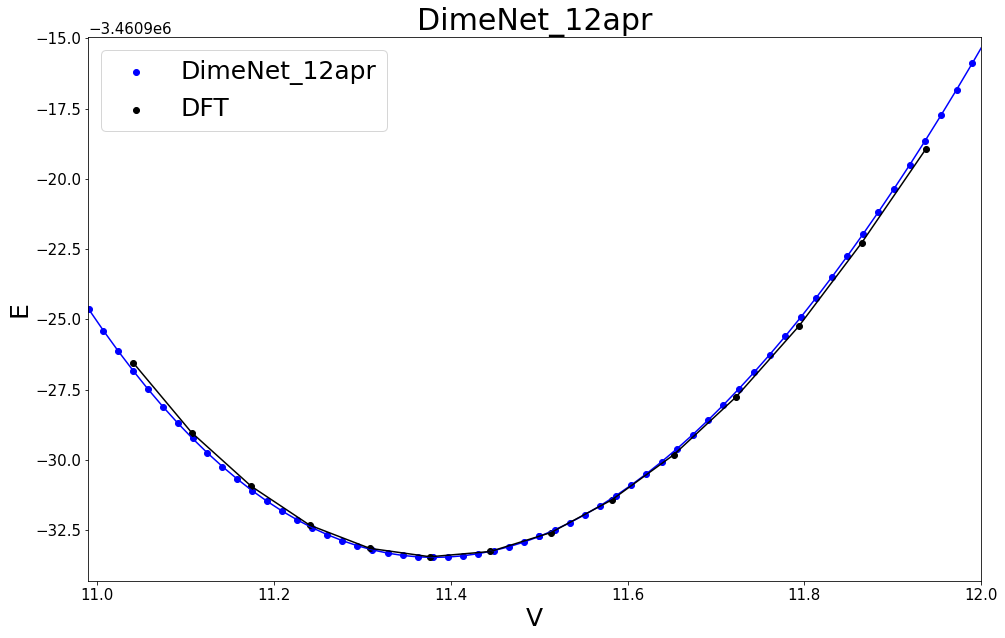

In [ ]:
eos_x_dimenet, eos_y_dimenet = eos(dimenet)
equation_of_state(dimenet_name, eos_x_dimenet, eos_y_dimenet, eos_x_dft, eos_y_dft)

generated 82 points


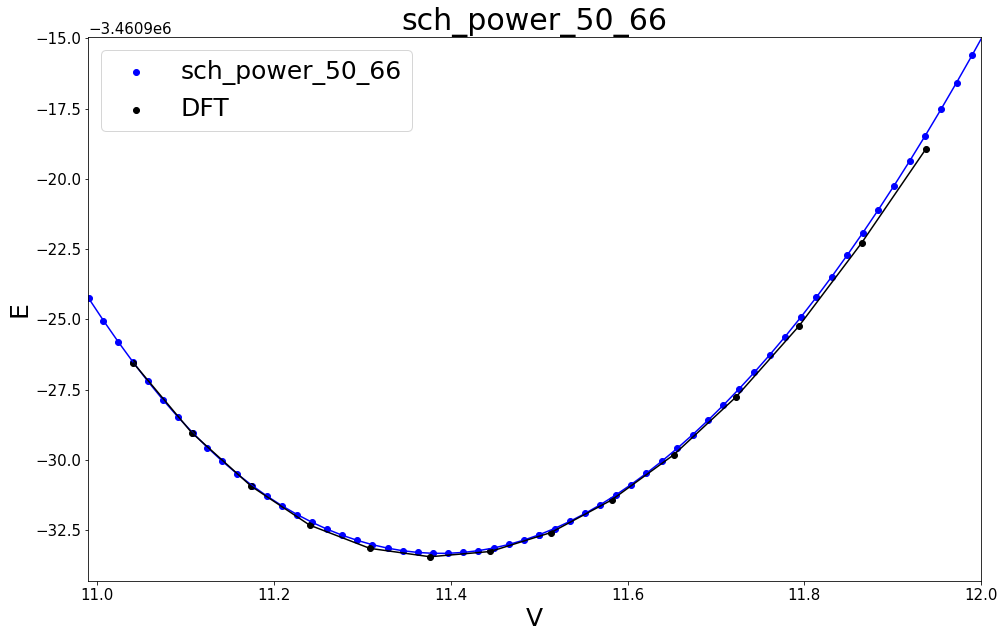

In [ ]:
eos_x_schnet, eos_y_schnet = eos(schnet)
equation_of_state(schnet_name, eos_x_schnet, eos_y_schnet, eos_x_dft, eos_y_dft)

## Dump

In [ ]:
print(f"EOS\n")
print()
print("DFT Dragoni")
print(f"X = {eos_x_dft}")
print(f"Y = {eos_y_dft}")
print()
print(schnet_name)
print(f"X = {eos_x_schnet}")
print(f"Y = {eos_y_schnet}")
print()
print(dimenet_name)
print(f"X = {eos_x_dimenet}")
print(f"Y = {eos_y_dimenet}")

EOS


DFT Dragoni
X = [11.937195803823421, 11.864683955482189, 11.793753661004313, 11.723015070025028, 11.652468182544332, 11.582112998562224, 11.513371319026572, 11.444837318281058, 11.376510996325683, 11.308392353160444, 11.240497364076894, 11.174263805314446, 11.106832099685818, 11.041061824378295]
Y = [-3460918.951310862, -3460922.284644195, -3460925.243445693, -3460927.752808989, -3460929.812734083, -3460931.423220974, -3460932.5842696633, -3460933.2584269666, -3460933.4456928843, -3460933.146067416, -3460932.3220973783, -3460930.9363295883, -3460929.0262172287, -3460926.554307116]

sch_power_50_66
X = [10.823824305325086, 10.840399837371784, 10.85699228322522, 10.873601651510494, 10.890227950852696, 10.906871189876927, 10.923531377208265, 10.94020852147182, 10.956902631292666, 10.973613715295908, 10.990341782106633, 11.007086840349944, 11.023848898650918, 11.040627965634657, 11.057424049926258, 11.0742371601508, 11.091067304933386, 11.107914492899111, 11.124778732673052, 11.14166

# **Bain path**

## Define functions

In [ ]:
import math
from math import sqrt
from torch_geometric.data import DataLoader
def bain_vo(model, a_coeff_min=0.95, a_coeff_max=1.05):

  a_0 = 2.83477
  #a_0 = 2.8325

  plot_x = []
  plot_y = []
  extra_x = []
  extra_y = []

  cas = []
  for sr_ in np.arange(0.5, 2.05, 0.02):
    sr = sr_.item()
    data_list = []

    r = sr**(2/3)
    a_c = r**(-1)
    a_tmp = np.arange(0.98*a_0,1.02*a_0,0.02)
    a_tmp = a_tmp.tolist()
    a_tmp.append(a_0)
    #print(a_tmp)
    #print(a_tmp)
    tmp_arr = []
    #print(sr)
    for current_a in a_tmp:
      cell = [[math.sqrt(a_c)*current_a, 0, 0], [0, math.sqrt(a_c)*current_a, 0], [math.sqrt(a_c)*current_a/2, math.sqrt(a_c)*current_a/2, (r)*current_a/2]]
      #print(cell)
      #cell = [[math.sqrt(a_c)*current_a, 0, 0], [0, math.sqrt(a_c)*current_a, 0], [0.0, 0.0, (r)*current_a/2]]
      positions = [[0.0, 0.0, 0.0]]
      data_list.append(data_object_da_vett(cell, positions, 0.0))

    model.eval()
    inputs = []
    candidate_ys = []
    test_loader = DataLoader(data_list, batch_size=1, shuffle=False)
    for data in test_loader:  # Iterate in batches over the training/test dataset.
      with torch.no_grad():
        out = model(data.charges, data.x, data.cell, data.batch)
        out = out.squeeze(1)
        if DB1x54:
          candidate_ys.append((out/ff).item())
        else:
          candidate_ys.append(out.item())
        inputs.append(data)

    plot_x.append(sr)
    #plot_x.append(r/sqrt(1/r))
    extra_x += [r/sqrt(1/r)]*len(candidate_ys)
    #extra_x += [r]*len(candidate_ys)

    #find the minimum energy and corresponding a value;
    j = 0
    ok = 0
    for i in range(len(candidate_ys)):
      if candidate_ys[i] < candidate_ys[j]:
        j = i

    cas.append(r)

    plot_y.append(min(candidate_ys))

    extra_y += candidate_ys

  return plot_x, plot_y, extra_x, extra_y, cas

In [ ]:
def bain_cv(model):

  a = 2.83477
  #a = 2.8325

  plot_x = []
  plot_y = []
  data_list = []
  data = []

  for sr_ in np.arange(0.5, 2, 0.02):
    sr = sr_.item()
    r = sr**(2/3)
    a_c = r**(-1)

    cell = [[sqrt(a_c)*a,0,0],[0,sqrt(a_c)*a,0],[sqrt(a_c)*a/2,sqrt(a_c)*a/2,(r)*a/2]]
    positions = [[0.0,0.0,0.0]]
    data_list.append(data_object_da_vett(cell, positions, 0.0))

    #plot_x.append(r)
    plot_x.append(r/sqrt(1/r))
  
  print([r.vol for r in data_list])
  print(len(data_list))
  test_loader = DataLoader(data_list, batch_size=1, shuffle=False)
  
  for data in test_loader:  # Iterate in batches over the training/test dataset.
    with torch.no_grad():
      out = model(data.charges, data.x, data.cell, data.batch)
      out = out.squeeze(1)
      if DB1x54:
        plot_y.append((out/torch.tensor(54, dtype=DTYPE)).item())
      else:
        plot_y.append(out.item())

  return plot_x, plot_y

## Load DFT data

In [ ]:
a = open(path2data + "DFT_figura3.csv", "r").read()
d = a.replace(";", "").replace(",",".").split()
bain_x_dft = [float(x) for i, x in enumerate(d) if i%2 == 0]
bain_y_dft = [float(x) for i, x in enumerate(d) if i%2 == 1]

## Plot

In [ ]:
def bain_path(model_name, calc_mode, model_x, model_y, dft_x, dft_y):
  plt.rcParams.update({'font.size':25})
  plt.rcParams.update({'axes.titlesize':30})
  plt.rcParams.update({'figure.titlesize':30})
  plt.rcParams.update({'xtick.labelsize':15})
  plt.rcParams.update({'ytick.labelsize':15})
  plt.rcParams.update({'legend.fontsize':20})

  fig, ax = plt.subplots(figsize=(16,10))
  plt.cla()
  ax.set_xlim(0.7, 2.05)
  #ax.set_xlim(0.97,1.03)
  #ax.set_ylim(-3.461e6, -3.4605e6)
  ax.set_ylim(min([y*1000 for y in model_y]) -50, -3.4605e6 + 90)
  #ax.set_ylim(-3.461e6, -3.4608e6)
  ax.set_title(model_name + " " + calc_mode)
  plt.xlabel("c/a")
  plt.ylabel("E")

  plt.axvline(x=0.8, linestyle='--', label="bct")
  plt.axvline(x=1.0, linestyle='--', color='orange', label="bcc")
  plt.axvline(x=math.sqrt(2), linestyle='--', color='brown', label="fcc")

  ax.scatter(dft_x, [en for en in dft_y], color="black", label="DFT")
  ax.plot(dft_x, [en for en in dft_y], color="black")

  ax.scatter(model_x, [(en*1000) for en in model_y], color="blue")
  ax.plot(model_x, [(en*1000) for en in model_y], color="blue", label=model_name + " Vol. Optimization")

  #ax.scatter(sch_x_cv, [(en*1000) for en in sch_y_cv], color="red")
  #ax.plot(sch_x_cv, [(en*1000) for en in sch_y_cv], color="red", label="SchNet Constant Vol.")

  ax.legend()

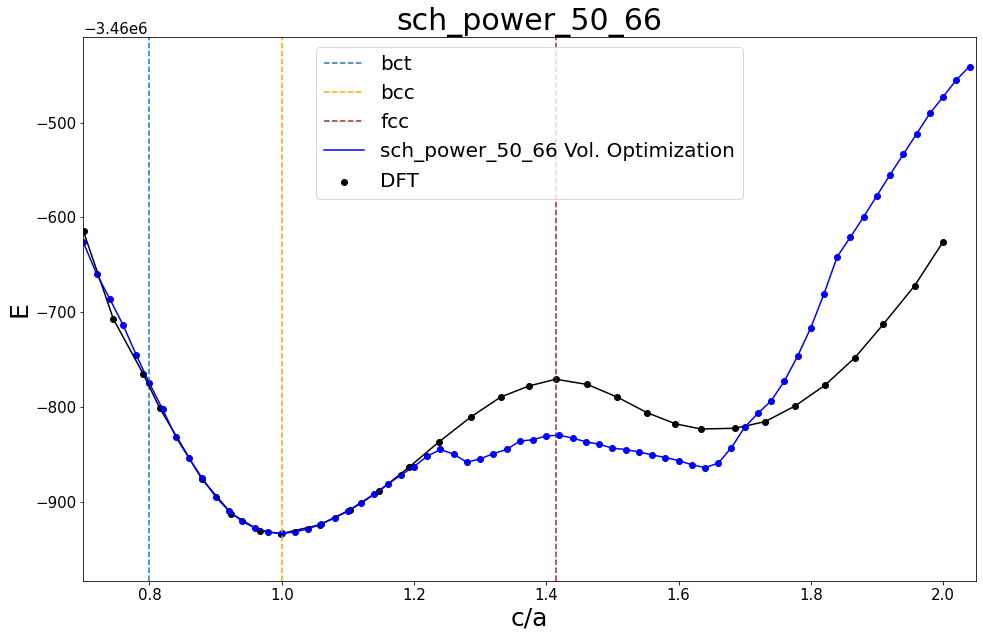

In [ ]:
bain_vo_x_schnet, bain_vo_y_schnet, _, _, _ = bain_vo(schnet)
bain_path(schnet_name, "VO", bain_vo_x_schnet, bain_vo_y_schnet, bain_x_dft, bain_y_dft)

[11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826156, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826161, 11.389993819826167, 11.389993819826161, 11.389993819826161, 11.389993819826161, 11.389993819826161, 11.389993819826161, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167,

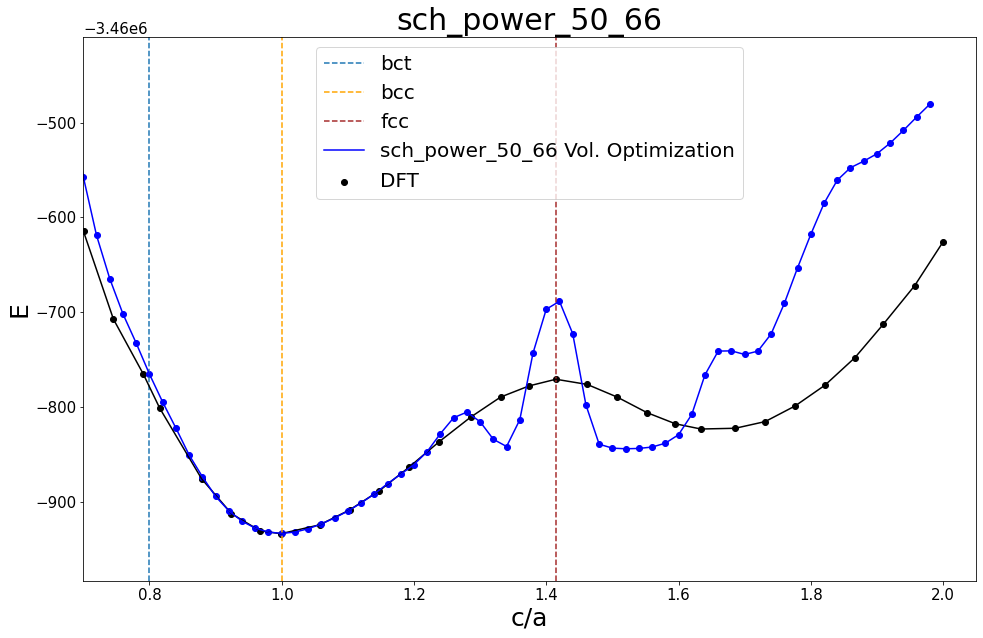

In [ ]:
bain_cv_x_schnet, bain_cv_y_schnet = bain_cv(schnet)
bain_path(schnet_name, "CV", bain_cv_x_schnet, bain_cv_y_schnet, bain_x_dft, bain_y_dft)

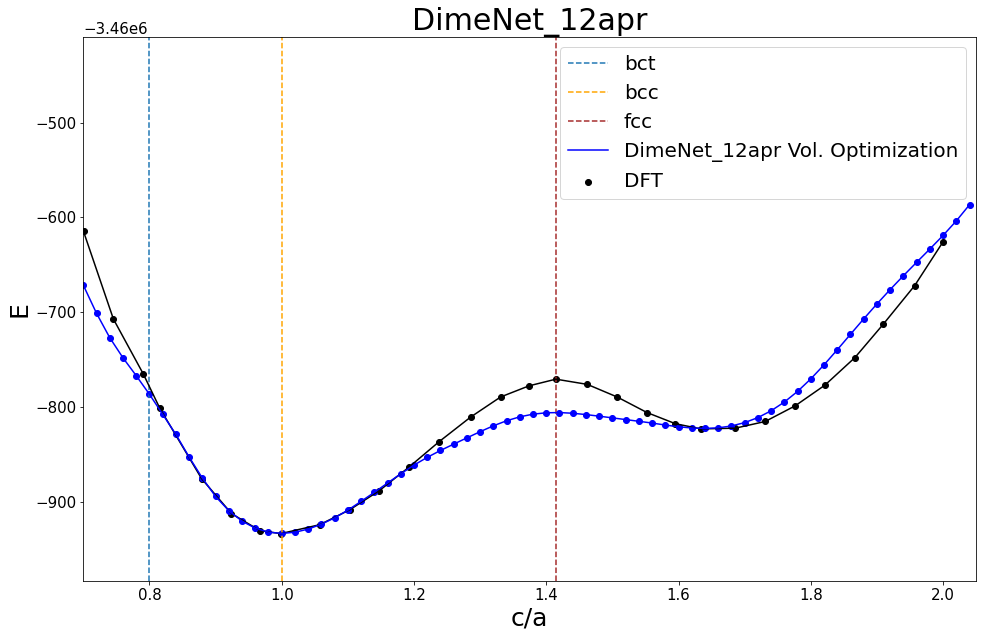

In [ ]:
bain_vo_x_dimenet, bain_vo_y_dimenet, _, _, _ = bain_vo(dimenet)
bain_path(dimenet_name, "VO", bain_vo_x_dimenet, bain_vo_y_dimenet, bain_x_dft, bain_y_dft)

[11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826156, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826161, 11.389993819826167, 11.389993819826161, 11.389993819826161, 11.389993819826161, 11.389993819826161, 11.389993819826161, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826161, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167, 11.389993819826167,

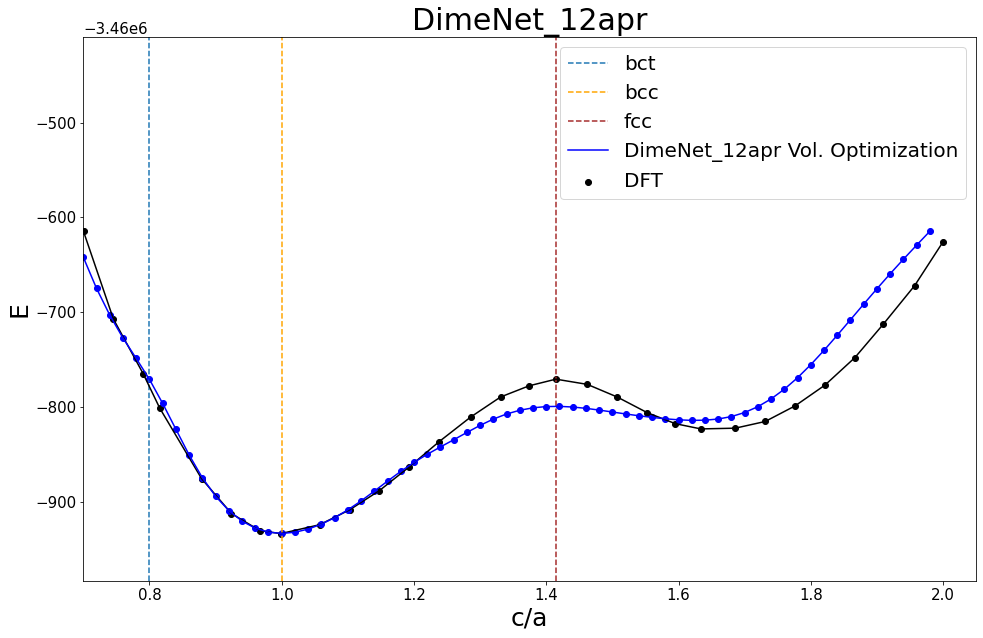

In [ ]:
bain_cv_x_dimenet, bain_cv_y_dimenet = bain_cv(dimenet)
bain_path(dimenet_name, "CV", bain_cv_x_dimenet, bain_cv_y_dimenet, bain_x_dft, bain_y_dft)

## Dump

In [ ]:
print(f"BAIN PATH\n")
print()
print("DFT Dragoni")
print(f"X = {bain_x_dft}")
print(f"Y = {bain_y_dft}")
print()
print(schnet_name + " cv")
print(f"X = {bain_cv_x_schnet}")
print(f"Y = {bain_cv_y_schnet}")
print()
print(schnet_name + " vo")
print(f"X = {bain_vo_x_schnet}")
print(f"Y = {bain_vo_y_schnet}")
print()
print(dimenet_name + " cv")
print(f"X = {bain_cv_x_dimenet}")
print(f"Y = {bain_cv_y_dimenet}")
print()
print(dimenet_name + " vo")
print(f"X = {bain_vo_x_dimenet}")
print(f"Y = {bain_vo_y_dimenet}")

BAIN PATH


DFT Dragoni
X = [0.7002712477396023, 0.7454792043399638, 0.7906871609403254, 0.8155515370705244, 0.8788426763110309, 0.9240506329113924, 0.9669981916817358, 0.9986437613019892, 1.0574141048824595, 1.102622061482821, 1.1478300180831826, 1.1930379746835444, 1.238245931283906, 1.2857142857142858, 1.3309222423146474, 1.373869801084991, 1.4145569620253164, 1.4620253164556962, 1.507233273056058, 1.5524412296564196, 1.5953887884267632, 1.6338155515370705, 1.6858047016274866, 1.7310126582278484, 1.77622061482821, 1.8214285714285716, 1.8666365280289332, 1.9095840867992768, 1.9570524412296564, 2.0]
Y = [-3460614.8825065275, -3460707.310704961, -3460765.274151436, -3460801.3054830288, -3460875.7180156657, -3460912.5326370755, -3460930.548302872, -3460933.6814621408, -3460924.2819843343, -3460908.6161879897, -3460888.2506527416, -3460863.18537859, -3460836.5535248043, -3460810.7049608356, -3460789.5561357704, -3460777.8067885116, -3460770.7571801567, -3460776.2402088773, -3460789.55613

# **Vacancy formation energy**

## Definizione dati

In [ ]:
#bravais lattice vectors
lei_128_lattice_str = """
 11.3360000   0.0000000   0.0000000 
  0.0000000  11.3360000   0.0000000 
  0.0000000   0.0000000  11.3360000 
""" 
#sites
lei_128_sites_str = """
Fe      0.0000000   0.0000000   0.0000000
Fe      1.4170000   1.4170000   1.4170000
Fe      8.5020000   0.0000000   2.8340000
Fe      5.6680000   5.6680000   0.0000000
Fe      8.5020000   2.8340000   0.0000000
Fe      2.8340000   2.8340000   5.6680000
Fe      2.8340000   8.5020000   8.5020000
Fe      0.0000000   0.0000000   8.5020000
Fe      5.6680000   5.6680000   8.5020000
Fe      0.0000000   2.8340000   5.6680000
Fe      5.6680000   0.0000000   5.6680000
Fe      8.5020000   2.8340000   8.5020000
Fe      0.0000000   5.6680000   2.8340000
Fe      2.8340000   0.0000000   5.6680000
Fe      8.5020000   5.6680000   5.6680000
Fe      0.0000000   8.5020000   0.0000000
Fe      2.8340000   2.8340000   2.8340000
Fe      8.5020000   8.5020000   2.8340000
Fe      2.8340000   5.6680000   0.0000000
Fe      5.6680000   8.5020000   5.6680000
Fe      5.6680000   0.0000000   2.8340000
Fe      5.6680000   2.8340000   0.0000000
Fe      5.6680000   2.8340000   2.8340000
Fe      8.5020000   0.0000000   0.0000000
Fe      0.0000000   8.5020000   8.5020000
Fe      2.8340000   5.6680000   8.5020000
Fe      2.8340000   8.5020000   5.6680000
Fe      0.0000000   0.0000000   5.6680000
Fe      5.6680000   2.8340000   8.5020000
Fe      8.5020000   0.0000000   8.5020000
Fe      0.0000000   2.8340000   2.8340000
Fe      5.6680000   5.6680000   5.6680000
Fe      8.5020000   2.8340000   5.6680000
Fe      0.0000000   5.6680000   0.0000000
Fe      2.8340000   0.0000000   2.8340000
Fe      8.5020000   5.6680000   2.8340000
Fe      2.8340000   2.8340000   0.0000000
Fe      5.6680000   8.5020000   2.8340000
Fe      8.5020000   8.5020000   0.0000000
Fe      5.6680000   0.0000000   0.0000000
Fe      0.0000000   5.6680000   8.5020000
Fe      0.0000000   8.5020000   5.6680000
Fe      2.8340000   2.8340000   8.5020000
Fe      8.5020000   8.5020000   8.5020000
Fe      2.8340000   5.6680000   5.6680000
Fe      5.6680000   0.0000000   8.5020000
Fe      2.8340000   8.5020000   2.8340000
Fe      0.0000000   0.0000000   2.8340000
Fe      5.6680000   2.8340000   5.6680000
Fe      8.5020000   0.0000000   5.6680000
Fe      0.0000000   2.8340000   0.0000000
Fe      5.6680000   5.6680000   2.8340000
Fe      8.5020000   2.8340000   2.8340000
Fe      2.8340000   0.0000000   0.0000000
Fe      5.6680000   8.5020000   0.0000000
Fe      8.5020000   5.6680000   0.0000000
Fe      0.0000000   2.8340000   8.5020000
Fe      5.6680000   8.5020000   8.5020000
Fe      0.0000000   5.6680000   5.6680000
Fe      2.8340000   0.0000000   8.5020000
Fe      8.5020000   5.6680000   8.5020000
Fe      0.0000000   8.5020000   2.8340000
Fe      8.5020000   8.5020000   5.6680000
Fe      2.8340000   5.6680000   2.8340000
Fe      2.8340000   8.5020000   0.0000000
Fe      9.9190000   1.4170000   4.2510000
Fe      7.0850000   7.0850000   1.4170000
Fe      9.9190000   4.2510000   1.4170000
Fe      4.2510000   4.2510000   7.0850000
Fe      4.2510000   9.9190000   9.9190000
Fe      1.4170000   1.4170000   9.9190000
Fe      7.0850000   7.0850000   9.9190000
Fe      1.4170000   4.2510000   7.0850000
Fe      7.0850000   1.4170000   7.0850000
Fe      9.9190000   4.2510000   9.9190000
Fe      1.4170000   7.0850000   4.2510000
Fe      4.2510000   1.4170000   7.0850000
Fe      9.9190000   7.0850000   7.0850000
Fe      1.4170000   9.9190000   1.4170000
Fe      4.2510000   4.2510000   4.2510000
Fe      9.9190000   9.9190000   4.2510000
Fe      4.2510000   7.0850000   1.4170000
Fe      7.0850000   9.9190000   7.0850000
Fe      7.0850000   1.4170000   4.2510000
Fe      7.0850000   4.2510000   1.4170000
Fe      7.0850000   4.2510000   4.2510000
Fe      9.9190000   1.4170000   1.4170000
Fe      1.4170000   9.9190000   9.9190000
Fe      4.2510000   7.0850000   9.9190000
Fe      4.2510000   9.9190000   7.0850000
Fe      1.4170000   1.4170000   7.0850000
Fe      7.0850000   4.2510000   9.9190000
Fe      9.9190000   1.4170000   9.9190000
Fe      1.4170000   4.2510000   4.2510000
Fe      7.0850000   7.0850000   7.0850000
Fe      9.9190000   4.2510000   7.0850000
Fe      1.4170000   7.0850000   1.4170000
Fe      4.2510000   1.4170000   4.2510000
Fe      9.9190000   7.0850000   4.2510000
Fe      4.2510000   4.2510000   1.4170000
Fe      7.0850000   9.9190000   4.2510000
Fe      9.9190000   9.9190000   1.4170000
Fe      7.0850000   1.4170000   1.4170000
Fe      1.4170000   7.0850000   9.9190000
Fe      1.4170000   9.9190000   7.0850000
Fe      4.2510000   4.2510000   9.9190000
Fe      9.9190000   9.9190000   9.9190000
Fe      4.2510000   7.0850000   7.0850000
Fe      7.0850000   1.4170000   9.9190000
Fe      4.2510000   9.9190000   4.2510000
Fe      1.4170000   1.4170000   4.2510000
Fe      7.0850000   4.2510000   7.0850000
Fe      9.9190000   1.4170000   7.0850000
Fe      1.4170000   4.2510000   1.4170000
Fe      7.0850000   7.0850000   4.2510000
Fe      9.9190000   4.2510000   4.2510000
Fe      4.2510000   1.4170000   1.4170000
Fe      7.0850000   9.9190000   1.4170000
Fe      9.9190000   7.0850000   1.4170000
Fe      1.4170000   4.2510000   9.9190000
Fe      7.0850000   9.9190000   9.9190000
Fe      1.4170000   7.0850000   7.0850000
Fe      4.2510000   1.4170000   9.9190000
Fe      9.9190000   7.0850000   9.9190000
Fe      1.4170000   9.9190000   4.2510000
Fe      9.9190000   9.9190000   7.0850000
Fe      4.2510000   7.0850000   4.2510000
Fe      4.2510000   9.9190000   1.4170000"""

lei_127_lattice_str = """
 11.3360000   0.0000000   0.0000000 
  0.0000000  11.3360000   0.0000000 
  0.0000000   0.0000000  11.3360000 
"""

lei_127_sites_str = """
Fe      1.4170000   1.4170000   1.4170000
Fe      8.5020000   0.0000000   2.8340000
Fe      5.6680000   5.6680000   0.0000000
Fe      8.5020000   2.8340000   0.0000000
Fe      2.8340000   2.8340000   5.6680000
Fe      2.8340000   8.5020000   8.5020000
Fe      0.0000000   0.0000000   8.5020000
Fe      5.6680000   5.6680000   8.5020000
Fe      0.0000000   2.8340000   5.6680000
Fe      5.6680000   0.0000000   5.6680000
Fe      8.5020000   2.8340000   8.5020000
Fe      0.0000000   5.6680000   2.8340000
Fe      2.8340000   0.0000000   5.6680000
Fe      8.5020000   5.6680000   5.6680000
Fe      0.0000000   8.5020000   0.0000000
Fe      2.8340000   2.8340000   2.8340000
Fe      8.5020000   8.5020000   2.8340000
Fe      2.8340000   5.6680000   0.0000000
Fe      5.6680000   8.5020000   5.6680000
Fe      5.6680000   0.0000000   2.8340000
Fe      5.6680000   2.8340000   0.0000000
Fe      5.6680000   2.8340000   2.8340000
Fe      8.5020000   0.0000000   0.0000000
Fe      0.0000000   8.5020000   8.5020000
Fe      2.8340000   5.6680000   8.5020000
Fe      2.8340000   8.5020000   5.6680000
Fe      0.0000000   0.0000000   5.6680000
Fe      5.6680000   2.8340000   8.5020000
Fe      8.5020000   0.0000000   8.5020000
Fe      0.0000000   2.8340000   2.8340000
Fe      5.6680000   5.6680000   5.6680000
Fe      8.5020000   2.8340000   5.6680000
Fe      0.0000000   5.6680000   0.0000000
Fe      2.8340000   0.0000000   2.8340000
Fe      8.5020000   5.6680000   2.8340000
Fe      2.8340000   2.8340000   0.0000000
Fe      5.6680000   8.5020000   2.8340000
Fe      8.5020000   8.5020000   0.0000000
Fe      5.6680000   0.0000000   0.0000000
Fe      0.0000000   5.6680000   8.5020000
Fe      0.0000000   8.5020000   5.6680000
Fe      2.8340000   2.8340000   8.5020000
Fe      8.5020000   8.5020000   8.5020000
Fe      2.8340000   5.6680000   5.6680000
Fe      5.6680000   0.0000000   8.5020000
Fe      2.8340000   8.5020000   2.8340000
Fe      0.0000000   0.0000000   2.8340000
Fe      5.6680000   2.8340000   5.6680000
Fe      8.5020000   0.0000000   5.6680000
Fe      0.0000000   2.8340000   0.0000000
Fe      5.6680000   5.6680000   2.8340000
Fe      8.5020000   2.8340000   2.8340000
Fe      2.8340000   0.0000000   0.0000000
Fe      5.6680000   8.5020000   0.0000000
Fe      8.5020000   5.6680000   0.0000000
Fe      0.0000000   2.8340000   8.5020000
Fe      5.6680000   8.5020000   8.5020000
Fe      0.0000000   5.6680000   5.6680000
Fe      2.8340000   0.0000000   8.5020000
Fe      8.5020000   5.6680000   8.5020000
Fe      0.0000000   8.5020000   2.8340000
Fe      8.5020000   8.5020000   5.6680000
Fe      2.8340000   5.6680000   2.8340000
Fe      2.8340000   8.5020000   0.0000000
Fe      9.9190000   1.4170000   4.2510000
Fe      7.0850000   7.0850000   1.4170000
Fe      9.9190000   4.2510000   1.4170000
Fe      4.2510000   4.2510000   7.0850000
Fe      4.2510000   9.9190000   9.9190000
Fe      1.4170000   1.4170000   9.9190000
Fe      7.0850000   7.0850000   9.9190000
Fe      1.4170000   4.2510000   7.0850000
Fe      7.0850000   1.4170000   7.0850000
Fe      9.9190000   4.2510000   9.9190000
Fe      1.4170000   7.0850000   4.2510000
Fe      4.2510000   1.4170000   7.0850000
Fe      9.9190000   7.0850000   7.0850000
Fe      1.4170000   9.9190000   1.4170000
Fe      4.2510000   4.2510000   4.2510000
Fe      9.9190000   9.9190000   4.2510000
Fe      4.2510000   7.0850000   1.4170000
Fe      7.0850000   9.9190000   7.0850000
Fe      7.0850000   1.4170000   4.2510000
Fe      7.0850000   4.2510000   1.4170000
Fe      7.0850000   4.2510000   4.2510000
Fe      9.9190000   1.4170000   1.4170000
Fe      1.4170000   9.9190000   9.9190000
Fe      4.2510000   7.0850000   9.9190000
Fe      4.2510000   9.9190000   7.0850000
Fe      1.4170000   1.4170000   7.0850000
Fe      7.0850000   4.2510000   9.9190000
Fe      9.9190000   1.4170000   9.9190000
Fe      1.4170000   4.2510000   4.2510000
Fe      7.0850000   7.0850000   7.0850000
Fe      9.9190000   4.2510000   7.0850000
Fe      1.4170000   7.0850000   1.4170000
Fe      4.2510000   1.4170000   4.2510000
Fe      9.9190000   7.0850000   4.2510000
Fe      4.2510000   4.2510000   1.4170000
Fe      7.0850000   9.9190000   4.2510000
Fe      9.9190000   9.9190000   1.4170000
Fe      7.0850000   1.4170000   1.4170000
Fe      1.4170000   7.0850000   9.9190000
Fe      1.4170000   9.9190000   7.0850000
Fe      4.2510000   4.2510000   9.9190000
Fe      9.9190000   9.9190000   9.9190000
Fe      4.2510000   7.0850000   7.0850000
Fe      7.0850000   1.4170000   9.9190000
Fe      4.2510000   9.9190000   4.2510000
Fe      1.4170000   1.4170000   4.2510000
Fe      7.0850000   4.2510000   7.0850000
Fe      9.9190000   1.4170000   7.0850000
Fe      1.4170000   4.2510000   1.4170000
Fe      7.0850000   7.0850000   4.2510000
Fe      9.9190000   4.2510000   4.2510000
Fe      4.2510000   1.4170000   1.4170000
Fe      7.0850000   9.9190000   1.4170000
Fe      9.9190000   7.0850000   1.4170000
Fe      1.4170000   4.2510000   9.9190000
Fe      7.0850000   9.9190000   9.9190000
Fe      1.4170000   7.0850000   7.0850000
Fe      4.2510000   1.4170000   9.9190000
Fe      9.9190000   7.0850000   9.9190000
Fe      1.4170000   9.9190000   4.2510000
Fe      9.9190000   9.9190000   7.0850000
Fe      4.2510000   7.0850000   4.2510000
Fe      4.2510000   9.9190000   1.4170000"""

lei_53_lattice_str = """
 8.5020000   0.0000000   0.0000000
 0.0000000   8.5020000   0.0000000
 0.0000000   0.0000000   8.5020000
"""

lei_53_sites_str = """
Fe            1.3710331141        1.3710328145        1.3710330239
Fe            2.8636873181        0.0000006056        0.0000002850
Fe            5.6383130622        0.0000006007        0.0000002554
Fe           -0.0000003236        0.0000005923        5.6383131764
Fe           -0.0000003588        5.6780135759        2.8239863030
Fe            2.8239871194        0.0000007435        5.6780131819
Fe            5.6780131857        0.0000007299        5.6780132388
Fe            2.8341486131        5.6678518988        2.8341480191
Fe            5.6678516811        5.6678519082        2.8341480047
Fe           -0.0000003414        2.8636857854        0.0000003193
Fe            2.8239869847        2.8239859741        0.0000003364
Fe            5.6780133287        2.8239860021        0.0000002954
Fe           -0.0000003894        2.8239858259        5.6780134613
Fe            2.8341485983        2.8341475140        5.6678517358
Fe            5.6678517287        2.8341475206        5.6678518095
Fe           -0.0000002984        0.0000005459        2.8636863926
Fe           -0.0000003480        5.6383133214        0.0000003529
Fe            2.8239870666        0.0000006725        2.8239865633
Fe            5.6780131849        0.0000006603        2.8239865538
Fe            2.8239870623        5.6780134537        0.0000003985
Fe            5.6780132879        5.6780134462        0.0000003540
Fe           -0.0000004008        5.6780135795        5.6780133363
Fe            2.8341486930        5.6678518824        5.6678515993
Fe            5.6678516714        5.6678518959        5.6678516707
Fe           -0.0000003469        2.8239859294        2.8239862830
Fe            2.8341485324        2.8341475875        2.8341479943
Fe            5.6678517451        2.8341475991        2.8341479618
Fe            4.2510003036        1.4201541600        1.4201542876
Fe            7.1309666303        1.3710328093        1.3710329475
Fe            1.3710331187        1.3710327648        7.1309672952
Fe            1.4201542656        7.0818467019        4.2509996322
Fe            4.2510003506        1.4201541416        7.0818459679
Fe            7.1309665941        1.3710327507        7.1309673430
Fe            4.2510003140        7.0939924882        4.2509997047
Fe            7.0818453833        7.0818466683        4.2509996776
Fe            1.4201540444        4.2509993812        1.4201540671
Fe            4.2510003236        4.2509994657        1.4080084858
Fe            7.0818455796        4.2509993973        1.4201540235
Fe            1.4201540621        4.2509993032        7.0818463141
Fe            4.2510003715        4.2509993925        7.0939919123
Fe            7.0818455294        4.2509993185        7.0818463189
Fe            1.4201542182        1.4201539663        4.2509997132
Fe            1.3710331908        7.1309676815        1.3710331340
Fe            4.2510002920        1.4080083865        4.2509997882
Fe            7.0818454339        1.4201539908        4.2509997531
Fe            4.2510003261        7.0818465133        1.4201543806
Fe            7.1309665364        7.1309676832        1.3710330651
Fe            1.3710332453        7.1309677188        7.1309671530
Fe            4.2510003731        7.0818465930        7.0818459245
Fe            7.1309664843        7.1309677507        7.1309672224
Fe            1.4080083930        4.2509994420        4.2509996333
Fe            4.2510003258        4.2509994018        4.2509996692
Fe            7.0939911399        4.2509994633        4.2509996798
"""

lei_54_lattice_str = """
 8.5020000   0.0000000   0.0000000
 0.0000000   8.5020000   0.0000000
 0.0000000   0.0000000   8.5020000
"""

lei_54_sites_str = """
Fe      0.0000000   0.0000000   0.0000000
Fe      1.4170000   1.4170000   1.4170000
Fe      2.8340000   0.0000000   0.0000000
Fe      5.6680000   0.0000000   0.0000000
Fe      0.0000000   0.0000000   5.6680000
Fe      0.0000000   5.6680000   2.8340000
Fe      2.8340000   0.0000000   5.6680000
Fe      5.6680000   0.0000000   5.6680000
Fe      2.8340000   5.6680000   2.8340000
Fe      5.6680000   5.6680000   2.8340000
Fe      0.0000000   2.8340000   0.0000000
Fe      2.8340000   2.8340000   0.0000000
Fe      5.6680000   2.8340000   0.0000000
Fe      0.0000000   2.8340000   5.6680000
Fe      2.8340000   2.8340000   5.6680000
Fe      5.6680000   2.8340000   5.6680000
Fe      0.0000000   0.0000000   2.8340000
Fe      0.0000000   5.6680000   0.0000000
Fe      2.8340000   0.0000000   2.8340000
Fe      5.6680000   0.0000000   2.8340000
Fe      2.8340000   5.6680000   0.0000000
Fe      5.6680000   5.6680000   0.0000000
Fe      0.0000000   5.6680000   5.6680000
Fe      2.8340000   5.6680000   5.6680000
Fe      5.6680000   5.6680000   5.6680000
Fe      0.0000000   2.8340000   2.8340000
Fe      2.8340000   2.8340000   2.8340000
Fe      5.6680000   2.8340000   2.8340000
Fe      4.2510000   1.4170000   1.4170000
Fe      7.0850000   1.4170000   1.4170000
Fe      1.4170000   1.4170000   7.0850000
Fe      1.4170000   7.0850000   4.2510000
Fe      4.2510000   1.4170000   7.0850000
Fe      7.0850000   1.4170000   7.0850000
Fe      4.2510000   7.0850000   4.2510000
Fe      7.0850000   7.0850000   4.2510000
Fe      1.4170000   4.2510000   1.4170000
Fe      4.2510000   4.2510000   1.4170000
Fe      7.0850000   4.2510000   1.4170000
Fe      1.4170000   4.2510000   7.0850000
Fe      4.2510000   4.2510000   7.0850000
Fe      7.0850000   4.2510000   7.0850000
Fe      1.4170000   1.4170000   4.2510000
Fe      1.4170000   7.0850000   1.4170000
Fe      4.2510000   1.4170000   4.2510000
Fe      7.0850000   1.4170000   4.2510000
Fe      4.2510000   7.0850000   1.4170000
Fe      7.0850000   7.0850000   1.4170000
Fe      1.4170000   7.0850000   7.0850000
Fe      4.2510000   7.0850000   7.0850000
Fe      7.0850000   7.0850000   7.0850000
Fe      1.4170000   4.2510000   4.2510000
Fe      4.2510000   4.2510000   4.2510000
Fe      7.0850000   4.2510000   4.2510000
"""

## Ottenimento DataObject

In [ ]:
def from_lei_lattice_sites(lattice_str, sites_str):
  lattice = list(map(float, lattice_str.strip().split()))
  sites = sites_str.strip().split("\n")
  sites = [x.replace("Fe", "").strip().split() for x in sites]
  sites = [ list(map(float, x)) for x in sites ]
  print(len(lattice), len(sites))
  return lattice, sites

In [ ]:
lei_128_lattice, lei_128_sites = from_lei_lattice_sites(lei_128_lattice_str, lei_128_sites_str) 
lei_127_lattice, lei_127_sites = from_lei_lattice_sites(lei_127_lattice_str, lei_127_sites_str) 
reshape = lambda x: [[x[0], x[1], x[2]],[x[3], x[4],x[5]], [x[6], x[7], x[8]] ]
lei_127_lattice = reshape(lei_127_lattice)
lei_128_lattice = reshape(lei_128_lattice)
lei_128 = data_object_da_vett(lei_128_lattice, lei_128_sites, 0.0)
lei_127 = data_object_da_vett(lei_127_lattice, lei_127_sites, 0.0)

lei_54_lattice, lei_54_sites = from_lei_lattice_sites(lei_54_lattice_str, lei_54_sites_str) 
lei_53_lattice, lei_53_sites = from_lei_lattice_sites(lei_53_lattice_str, lei_53_sites_str) 
lei_53_lattice = reshape(lei_53_lattice)
lei_54_lattice = reshape(lei_54_lattice)
lei_54 = data_object_da_vett(lei_54_lattice, lei_54_sites, 0.0)
lei_53 = data_object_da_vett(lei_53_lattice, lei_53_sites, 0.0)

9 128
9 127
9 54
9 53


In [ ]:
lei_54

Data(cell=[3, 3], charges=[54], n=54, vol=614.5586020079999, x=[54, 3], y=0.0)

In [ ]:
from torch_geometric.data import DataLoader
loader_128 = DataLoader([lei_128, lei_127], batch_size=1, shuffle=False)
loader_54 = DataLoader([lei_54, lei_53], batch_size=1, shuffle=False)

## Definizione funzioni

In [ ]:
def eval_vacancy(loader):
  ycap = []
  for data in loader:  # Iterate in batches over the training/test dataset.
    with torch.no_grad():
      out = model(data.charges, data.x, data.cell, data.batch)
      out = out.squeeze(1)
      ycap.append(out.item())
  return ycap

In [ ]:
def vacancy_formation_energy(N, E_total, E_total_v):
  print(model_name)
  print("{} -> {}".format(N, N-1))
  print("E_total_v =", E_total_v)
  print("E_total = ", E_total)
  print("E_v = E_total_v - E_total*(N-1)/N =", E_total_v - (E_total*(N-1)/N))
  if N == 54:
    target = 2.27723546
  elif N == 128:
    target = 2.489209848987993
  else:
    target = "unknown"
  print(f"(target: {target})")

## Valutazione

In [ ]:
E_total, E_total_v = eval_vacancy(loader_54)
vacancy_formation_energy(54, E_total, E_total_v)

sch_power_50_66
54 -> 53
E_total_v = -183426.64447632173
E_total =  -186890.39947985398
E_v = E_total_v - E_total*(N-1)/N = 2.8216798312496394
(target: 2.27723546)


In [ ]:
E_total, E_total_v = eval_vacancy(loader_128)
vacancy_formation_energy(128, E_total, E_total_v)

sch_power_50_66
128 -> 127
E_total_v = -439536.4015979925
E_total =  -442999.46543372946
E_v = E_total_v - E_total*(N-1)/N = 2.1305120359174907
(target: 2.489209848987993)


# **Tutto**

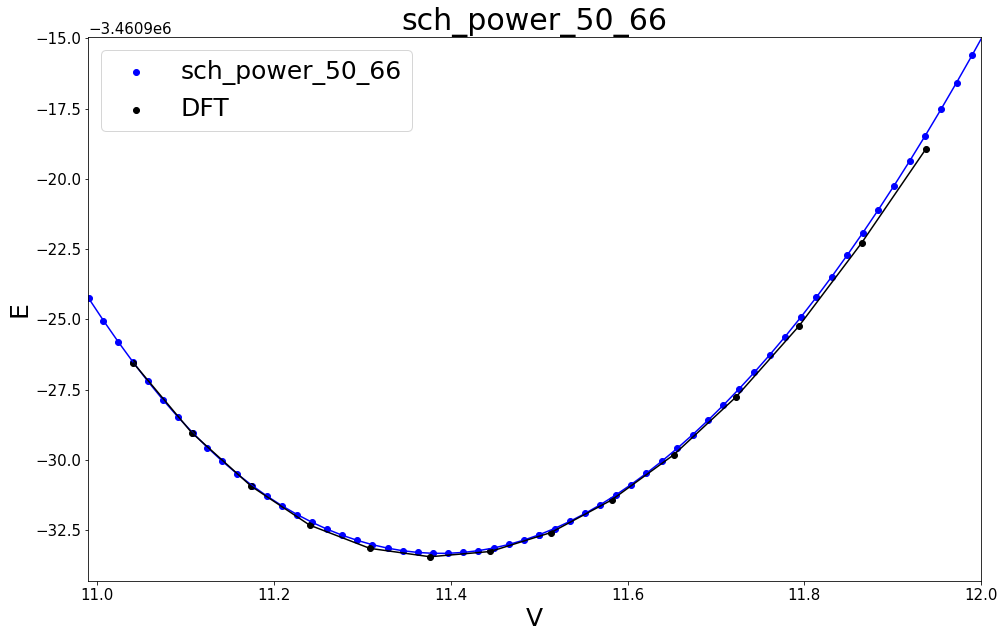

sch_power_50_66
54 -> 53
E_total_v = -183426.64447632173
E_total =  -186890.39947985398
E_v = E_total_v - E_total*(N-1)/N = 2.8216798312496394
(target: 2.27723546)
sch_power_50_66
128 -> 127
E_total_v = -439536.4015979925
E_total =  -442999.46543372946
E_v = E_total_v - E_total*(N-1)/N = 2.1305120359174907
(target: 2.489209848987993)


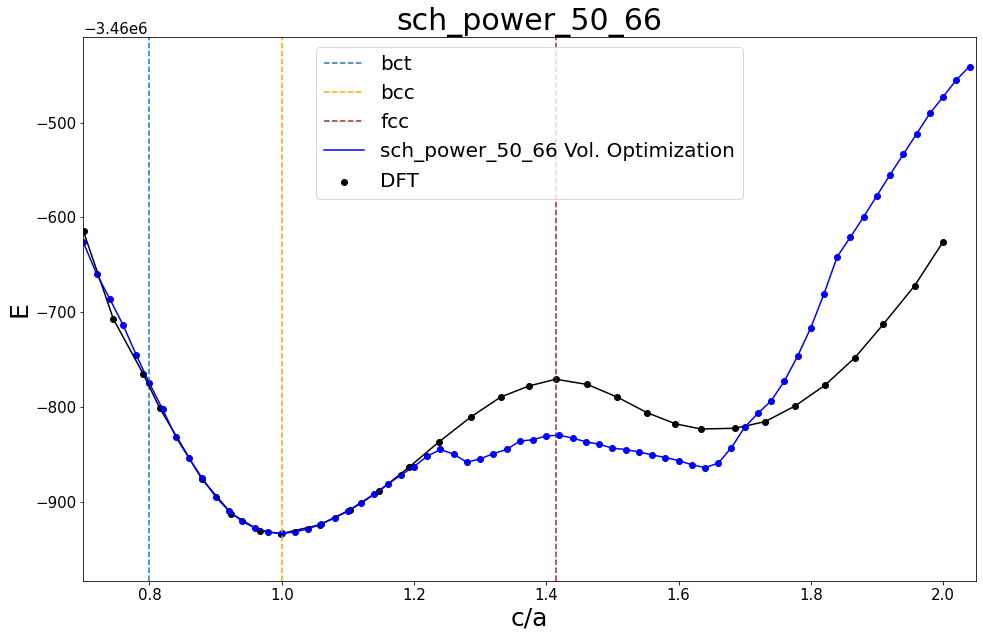

In [ ]:
equation_of_state()
bain_path()
E_total, E_total_v = eval_vacancy(loader_54)
vacancy_formation_energy(54, E_total, E_total_v)
E_total, E_total_v = eval_vacancy(loader_128)
vacancy_formation_energy(128, E_total, E_total_v)

# **Surface energy**


## Deprecated (?)

In [ ]:
import re
def get_cell(configuration_string):
  for line in configuration_string.split("\n"):
    if line.find("xlo xhi") != -1:
      xlo, xhi = [float(v) for v in re.sub("\s+"," ", line).strip().split(" ")[:2]]
    if line.find("ylo yhi") != -1:
      ylo, yhi = [float(v) for v in re.sub("\s+"," ", line).strip().split(" ")[:2]]
    if line.find("zlo zhi") != -1:
      zlo, zhi = [float(v) for v in re.sub("\s+"," ", line).strip().split(" ")[:2]]
  return [[xhi-xlo, 0.0, 0.0], [0.0, yhi-ylo, 0.0], [0.0, 0.0, zhi-zlo]]

def get_positions(configuration_string):
  configuration_string = configuration_string.split("Atoms")[1]
  positions = []
  for line in configuration_string.split("\n")[2:-1]:
    xyz = re.sub("\s+"," ", line).strip().split(" ")[2:]
    positions.append([float(v) for v in xyz])
  return positions

In [ ]:
SOURCE_DATA_PATH = "/content/drive/My Drive/progetto-atomico/data/evaluation/surface-energy/original/"
DEST_DATA_PATH = "/content/drive/My Drive/progetto-atomico/data/evaluation/surface-energy/"

In [ ]:
SOURCE_FN = "lmpmodel_112_surf"
DEST_FN = "surf_112.pt"

In [ ]:
with open(DATA_PATH + SOURCE_FN) as f:
  s = f.read()
pprint(get_cell(s))
pprint(len(get_positions(s)))
pprint(get_positions(s))
dobj = data_object_da_vett(get_cell(s), get_positions(s))

In [ ]:
torch.save(dobj, DEST_DATA_PATH + DEST_FN)

## Evaluation

In [ ]:
DATA_PATH = "/content/drive/My Drive/progetto-atomico/data/evaluation/surface-energy/"

In [ ]:
def eV_to_J(e):
  return e / 6.242e+18

In [ ]:
def A_to_m(l):
  return l / 1e+10

In [ ]:
def evaluate(model, data_list):
  loader = DataLoader(data_list, batch_size=1, shuffle=False)
  model.eval()
  ycap = []
  for data in loader:
    with torch.no_grad():
      out = model(data.charges, data.x, data.cell, data.batch)
      out = out.squeeze(1)
      ycap.append(out.item())
  return ycap

In [ ]:
def surface_energy(model, bulk, surf, id):
  print(model_name)
  
  A = bulk.cell[1][1].item() * bulk.cell[2][2].item()
  print(f"A_{id}: {A}")
  
  E_bulk, E_surf = evaluate(model, [bulk, surf])
  print(f"E_bulk_{id}: {E_bulk}")
  print(f"E_surf_{id}: {E_surf}")

  gamma_surf = (E_surf - E_bulk) / (2 * A)

  E_bulk_J, E_surf_J = eV_to_J(E_bulk), eV_to_J(E_surf)
  A_m = A_to_m(bulk.cell[1][1].item()) * A_to_m(bulk.cell[2][2].item())
  gamma_surf_J_m2 = (E_surf_J - E_bulk_J) / (2 * A_m)

  print(f"gamma_surf_{id}: {gamma_surf} (eV/A^2) = {gamma_surf_J_m2} (J/m^2)")
  return gamma_surf

### (100)


In [ ]:
bulk_100 = torch.load(DATA_PATH + "bulk_100.pt")
surf_100 = torch.load(DATA_PATH + "surf_100.pt")
gamma_surf_100 = surface_energy(model, bulk_100, surf_100, "100")

sch_power_50_66
A_100: 8.031556
E_bulk_100: -83062.39976882399
E_surf_100: -83059.77537922942
gamma_surf_100: 0.16337989765409777 (eV/A^2) = 2.6174286711613295 (J/m^2)


### (110)

In [ ]:
bulk_110 = torch.load(DATA_PATH + "bulk_110.pt")
surf_110 = torch.load(DATA_PATH + "surf_110.pt")
gamma_surf_110 = surface_energy(model, bulk_110, surf_110, "110")

sch_power_50_66
A_110: 11.358331920000001
E_bulk_110: -110749.86635834254
E_surf_110: -110746.26251682237
gamma_surf_110: 0.15864308005545366 (eV/A^2) = 2.5415424552281025 (J/m^2)


### (111)

In [ ]:
bulk_111 = torch.load(DATA_PATH + "bulk_111.pt")
surf_111 = torch.load(DATA_PATH + "surf_111.pt")
gamma_surf_111 = surface_energy(model, bulk_111, surf_111, "111")

sch_power_50_66
A_111: 27.822101778
E_bulk_111: -332249.59907461697
E_surf_111: -332240.8625900515
gamma_surf_111: 0.1570061930473806 (eV/A^2) = 2.5153186966973684 (J/m^2)


### (112)

In [ ]:
bulk_112 = torch.load(DATA_PATH + "bulk_112.pt")
surf_112 = torch.load(DATA_PATH + "surf_112.pt")
gamma_surf_112 = surface_energy(model, bulk_112, surf_112, "112")

sch_power_50_66
A_112: 19.673200004399998
E_bulk_112: -249187.19930594403
E_surf_112: -249179.89066323914
gamma_surf_112: 0.1857512428900538 (eV/A^2) = 2.975828947290107 (J/m^2)


# Rest

## DimeNet definition

In [ ]:
#@title  { vertical-output: true, form-width: "25%" }
from torch_geometric.nn import DimeNet
from torch_geometric.nn.acts import swish
from math import sqrt, pi as PI

import numpy as np
import torch
from torch.nn import Linear, Embedding
from torch_scatter import scatter
from torch_sparse import SparseTensor
from torch_geometric.nn import radius_graph
from torch_geometric.data import download_url
from torch_geometric.data.makedirs import makedirs

from torch_geometric.nn.models.dimenet import Envelope
from torch_geometric.nn.models.dimenet import BesselBasisLayer
from torch_geometric.nn.models.dimenet import SphericalBasisLayer
from torch_geometric.nn.models.dimenet import ResidualLayer
from torch_geometric.nn.models.dimenet import InteractionBlock
from torch_geometric.nn.models.dimenet import OutputBlock

from torch_geometric.nn.models.dimenet_utils import bessel_basis, real_sph_harm

try:
    import sympy as sym
except ImportError:
    sym = None

import os
try:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    import tensorflow as tf
except ImportError:
    tf = None


qm9_target_dict = {
    0: 'mu',
    1: 'alpha',
    2: 'homo',
    3: 'lumo',
    5: 'r2',
    6: 'zpve',
    7: 'U0',
    8: 'U',
    9: 'H',
    10: 'G',
    11: 'Cv',
}

# Implement PBC
from ase.neighborlist import neighbor_list 
from ase import Atoms


class EmbeddingBlock(torch.nn.Module):
    def __init__(self, num_radial, hidden_channels, act=swish):
        super(EmbeddingBlock, self).__init__()
        self.act = act

        self.emb = Embedding(95, hidden_channels)
        self.lin_rbf = Linear(num_radial, hidden_channels, bias=False)
        self.lin = Linear(3 * hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.emb.weight.data.uniform_(-sqrt(3), sqrt(3))
        self.lin_rbf.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, x, rbf, i, j):
        x = self.emb(x)
        #rbf = self.act(self.lin_rbf(rbf)) # FIX: this should not have an activation function
        rbf = self.lin_rbf(rbf)
        return self.act(self.lin(torch.cat([x[i], x[j], rbf], dim=-1)))

class DimeNet2(DimeNet):
  
  def __init__(self, hidden_channels, out_channels, num_blocks, num_bilinear,
                 num_spherical, num_radial, cutoff=5.0, envelope_exponent=5,
                 num_before_skip=1, num_after_skip=2, num_output_layers=3,
                 act=swish,
                 mean=None, std=None):
          super(DimeNet, self).__init__()

          self.cutoff = cutoff

          #set mean and standard deviation of energies
          self.mean = mean 
          self.std = std

          # padding used for PBCs
          self.padding = torch.nn.ConstantPad2d((0,6,0,0), 0)

          if sym is None:
              raise ImportError('Package `sympy` could not be found.')

          self.num_blocks = num_blocks

          self.rbf = BesselBasisLayer(num_radial, cutoff, envelope_exponent)
          self.sbf = SphericalBasisLayer(num_spherical, num_radial, cutoff,
                                          envelope_exponent)

          self.emb = EmbeddingBlock(num_radial, hidden_channels, act)

          self.output_blocks = torch.nn.ModuleList([
              OutputBlock(num_radial, hidden_channels, out_channels,
                          num_output_layers, act) for _ in range(num_blocks + 1)
          ])

          self.interaction_blocks = torch.nn.ModuleList([
              InteractionBlock(hidden_channels, num_bilinear, num_spherical,
                                num_radial, num_before_skip, num_after_skip, act)
              for _ in range(num_blocks)
          ])

          self.reset_parameters()

            
  def pbc_edges(self, z, pos, cell, batch):
        if cell is None:
            return
        tmp_z = z.cpu()
        tmp_pos = pos.cpu()
        tmp_cell = cell.cpu()
        nh1_tmp = np.array([]) # will contain all connection from node i
        nh2_tmp = np.array([]) # .. to node j
        dist_tmp = np.array([]) # distances between (i,j)
        shift_cells_tmp = None # bravais lattice multiplied by shift for the connection
        shift_tmp = None
        if batch is not None: #batch input
            tmp_batch = np.array(batch.cpu())
            batch_size = []
            found_b = []
            for b in tmp_batch: # create an array with each element being the dim of the corresponding index batch
                if b not in found_b:
                    found_b.append(b)
                    batch_size.append((tmp_batch == b).sum())
            for i in range(len(batch_size)):
                prev_sum = sum(batch_size[:i])
                current_z = tmp_z[prev_sum:batch_size[i]+prev_sum]
                # create the atomic structure
                atms = Atoms(charges=current_z, 
                                         positions=tmp_pos[prev_sum:batch_size[i]+prev_sum], 
                                         cell=tmp_cell[3*i:3*(i+1)], pbc=True) 
                # get the connections for the atomic structure w/ distances and shift
                nh1, nh2, dist, shift = neighbor_list("ijdS", atms, 
                                                                             self.cutoff, 
                                                                             self_interaction=False) 
                nh1 = nh1 + prev_sum # adds the number of previous elements to the atom index
                nh2 = nh2 + prev_sum
                nh1_tmp = np.concatenate((nh1_tmp, np.array(nh1)))
                nh2_tmp = np.concatenate((nh2_tmp, np.array(nh2)))
                dist_tmp = np.concatenate((dist_tmp, np.array(dist)))
                # Mult cells array (9 elements each) for each connection element in the batch
                cell_arr = np.asarray(tmp_cell[3*i:3*(i+1)]).reshape(-1)
                repeat = np.tile(cell_arr, (len(dist), 1))
                # multiply cell values by shift
                repeat[:, 0:3] = (repeat[:, 0:3].T * shift[:, 0]).T
                repeat[:, 3:6] = (repeat[:, 3:6].T * shift[:, 1]).T
                repeat[:, 6:9] = (repeat[:, 6:9].T * shift[:, 2]).T
                if shift_cells_tmp  is None:
                    shift_cells_tmp  = np.matrix(repeat)
                else:
                    shift_cells_tmp  = np.concatenate((shift_cells_tmp, repeat))
                if shift_tmp is None:
                    shift_tmp = np.matrix(shift)
                else:
                    shift_tmp = np.concatenate((shift_tmp, shift))
        else: # single cell input
                # create the atomic structure
                atms = Atoms(charges=tmp_z, 
                                         positions=tmp_pos, 
                                         cell=tmp_cell, pbc=True)
                # get the connections for the atomic structure w/ distances and shift
                nh1, nh2, dist, shift = neighbor_list("ijdS", atms, 
                                                                             self.cutoff, 
                                                                             self_interaction=False)
                nh1_tmp = np.concatenate((nh1_tmp, np.array(nh1)))
                nh2_tmp = np.concatenate((nh2_tmp, np.array(nh2)))
                dist_tmp = np.concatenate((dist_tmp, np.array(dist)))
                # Mult cells array (9 elements each) for each connection element in the batch
                cell_arr = np.asarray(tmp_cell).reshape(-1)
                repeat = np.tile(cell_arr, (len(dist), 1))
                # multiply cell values by shift
                repeat[:,0:3] = (repeat[:, 0:3].T * shift[:, 0]).T
                repeat[:,3:6] = (repeat[:, 3:6].T * shift[:, 1]).T
                repeat[:,6:9] = (repeat[:, 6:9].T * shift[:, 2]).T
                shift_cells_tmp = np.matrix(repeat)
        return [torch.tensor(nh1_tmp, dtype = torch.long).to(z.device), 
                        torch.tensor(nh2_tmp, dtype = torch.long).to(z.device), 
                        torch.tensor(dist_tmp, dtype = DTYPE).to(z.device),
                        torch.tensor(shift_cells_tmp, dtype = DTYPE).to(z.device),
                        torch.tensor(shift_tmp, dtype = torch.long).to(z.device)]

  def triplets_original(self, edge_index, num_nodes):
        row, col = edge_index  # j->i

        value = torch.arange(row.size(0), device=row.device)
        adj_t = SparseTensor(row=col, col=row, value=value,
                             sparse_sizes=(num_nodes, num_nodes))
        adj_t_row = adj_t[row]
        num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

        # Node indices (k->j->i) for triplets.
        idx_i = col.repeat_interleave(num_triplets)
        idx_j = row.repeat_interleave(num_triplets)
        idx_k = adj_t_row.storage.col()
        mask = (idx_i != idx_k)  # Remove i == k triplets.
        idx_i, idx_j, idx_k = idx_i[mask], idx_j[mask], idx_k[mask]

        # Edge indices (k-j, j->i) for triplets.
        idx_kj = adj_t_row.storage.value()[mask]
        idx_ji = adj_t_row.storage.row()[mask]

        return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji


  def triplets(self, edge_index, num_nodes, shift_cells=None, shift=None):
        row, col = edge_index  # j->i

        value = torch.arange(row.size(0), device=row.device)
        adj_t = SparseTensor(row=col, col=row, value=value,
                             sparse_sizes=(num_nodes, num_nodes))
        adj_t_row = adj_t[row]
        num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

        #print('edge_index : ', edge_index)
        # print('len edge_index : ', row.size())
        # print('adj_t : ', adj_t)
        # print('adj_t_row : ', adj_t_row)
        #print('shift : ', shift)
        #print('shift.size() : ', shift.size())
        #print('shift_cells : ', shift_cells)
        #print('shift_cells.size() : ', shift_cells.size())
        # print('shift_row.size() : ', shift_row.size())
        # print('num_nodes : ', num_nodes)
        # print('num_triplets : ', num_triplets)

        # Node indices (k->j->i) for triplets.
        idx_i = col.repeat_interleave(num_triplets)
        idx_j = row.repeat_interleave(num_triplets)
        idx_k = adj_t_row.storage.col()

        # print('idx_i : ', idx_i)
        # print('idx_i.size() : ', idx_i.size())
        # print('idx_j : ', idx_j)
        # print('idx_j.size() : ', idx_j.size())

        if shift_cells is not None: # Update also the shift vectors
            shift_cells_i = shift_cells.repeat_interleave(num_triplets, dim=0)
            shift_i = shift.repeat_interleave(num_triplets, dim=0)
            shift_cells_k = -shift_cells[adj_t_row.storage.value()]
            shift_k = -shift[adj_t_row.storage.value()]

        # print('idx_k : ', idx_k)
        # print('idx_k.size() : ', idx_k.size())
        # print('shift_k : ', shift_k)
        # print('-shift_k : ', -shift_k)
        # print('shift_k.size() : ', shift_k.size())
        # print('shift_cells_k[:, 3:6] : ', shift_cells_k[:, 3:6])
        # print('shift_cells_k.size() : ', shift_cells_k.size())
        # print('adj_t_row.storage.value() : ', adj_t_row.storage.value())
        # print('shift_cells : ', shift_cells)
        # print('shift_cells.size() : ', shift_cells.size())

        # i_i = torch.cat((torch.unsqueeze(idx_i, 1), shift_i), dim=1)
        # i_k = torch.cat((torch.unsqueeze(idx_k, 1), shift_k), dim=1)
        # i_j = torch.unsqueeze(idx_j, 1)
        # print('i_i: ', i_i)
        # print('i_i.size(): ', i_i.size())
        # print('i_j: ', i_j)
        # print('i_j.size(): ', i_j.size())
        # print('i_k: ', i_k)
        # print('i_k.size(): ', i_k.size())
        # uni = torch.cat((i_i, i_j, i_k), dim=1)  # gl debug
        # for u in uni:
        #     print(u)
        # print('uni.size() : ', uni.size())
        # uni = torch.unique(uni, dim=0)  # gl debug
        # print('uni.size() : ', uni.size())
        # nota: mask è True quando la cella e lo shift sono uguali, quindi poi bisogna prendere la negazione ~mask
        # mask = torch.all((torch.cat((torch.unsqueeze(idx_i, 1), shift_cells), dim=1) ==\
        #                   torch.cat((torch.unsqueeze(idx_k, 1), shift_cells), dim=1)), dim=1)
        # mask = torch.all((i_i == i_k), dim=1)
        mask = torch.all((torch.cat((torch.unsqueeze(idx_i, 1), shift_i), dim=1) ==\
                          torch.cat((torch.unsqueeze(idx_k, 1), shift_k), dim=1)), dim=1)

        # # mask = (idx_i != idx_k)  # Remove i == k triplets.
        # print('mask: ', mask)
        # print('mask.size(): ', mask.size())
        # print('shift_cells1: ', shift_cells)
        # print('shift_cells1.size(): ', shift_cells.size())
        # print('shift1: ', shift)
        # print('shift1.size(): ', shift.size())
        idx_i, idx_j, idx_k = idx_i[~mask], idx_j[~mask], idx_k[~mask]
        if shift_cells is not None: # Remove also from the shift vector
            shift_cells_i = shift_cells_i[~mask]
            shift_cells_k = shift_cells_k[~mask]
            shift_i = shift_i[~mask]
            shift_k = shift_k[~mask]
        # print('triplette finali: ', torch.sum(~mask==True))
        # print('shift_cells2: ', shift_cells)
        # print('shift_cells2.size(): ', shift_cells.size())
        # print('shift2: ', shift)
        # print('shift2.size(): ', shift.size())

        # Edge indices (k-j, j->i) for triplets.
        idx_kj = adj_t_row.storage.value()[~mask]
        idx_ji = adj_t_row.storage.row()[~mask]
        # print('idx_kj : ', idx_kj)
        # print('idx_kj.size() : ', idx_kj.size())
        # print('idx_ji : ', idx_ji)
        # print('idx_ji.size() : ', idx_ji.size())

        return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji, shift_cells_i, shift_i, shift_cells_k, shift_k


  def forward(self, z, pos, cell=None, batch=None):
        
        edge_index = []
        dist = []
        shift_cells = None
        # cell = None  ### gl: to be commented for PBC
        if cell is not None: # implement PBC
            # print('cell : ', cell)
            # print('cell.size() : ', cell.size())
            r1, r2, dist, shift_cells, shift = self.pbc_edges(z, pos, cell, batch)
            edge_index = [r1, r2]

            # gl: debug
            # for rr1, rr2, p1, p2, ss, cc, dd in zip(r1, r2, pos[r1], pos[r2], shift, shift_cells, dist):
            #     print('riga pre: ', rr1.item(), rr2.item(), p1, p2, ss, cc, dd.item(), \
            #           p2 + cc[0:3] + cc[3:6] + cc[6:9], \
            #           (p1 - (p2 + cc[0:3] + cc[3:6] + cc[6:9])).pow(2).sum(dim=-1).sqrt().item())
            # gl: fin qui pare bene, i conti battono. Quindi il problema è comunque triplets

            # print('shift_cells : ', shift_cells)
            # print('shift_cells.size() : ', shift_cells.size())
            # print('z : ', z)
            # print('shift : ', shift)
            # print('shift.size() : ', shift.size())
            # i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji, shift_cells, shift = self.triplets(
            #     edge_index, num_nodes=z.size(0), shift_cells=shift_cells, shift=shift)        
            i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji, shift_cells_i, shift_i, shift_cells_k, shift_k = self.triplets(
                edge_index, num_nodes=z.size(0), shift_cells=shift_cells, shift=shift)        
        else: # old method without PBC
            edge_index = radius_graph(pos, r=self.cutoff, batch=batch)
            i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji = self.triplets_original(
                edge_index, num_nodes=z.size(0))        
            dist = (pos[i] - pos[j]).pow(2).sum(dim=-1).sqrt()

        # print('edge_index : ', edge_index)
        # print('dist : ', dist)
        # print('dist.size() : ', dist.size())
        # print('different dist : ', torch.unique(dist))
        # print('different dist size() : ', torch.unique(dist).size())

        # Define atoms position 
        pos_i = pos[idx_i]
        pos_j = pos[idx_j]
        pos_k = pos[idx_k]

        # #print(len(pos_i))
        # #print(len(shift))
        # print()
        # print('pos_i:', pos_i)
        # print('pos_j:', pos_j)
        # print('pos_k:', pos_k)
        # print('idx_kj :', idx_kj)
        # print('idx_kj.size() :', idx_kj.size())
        # print('idx_ji :', idx_ji)
        # print('idx_ji.size() :', idx_ji.size())
        
        if cell is not None: # Fix coordinates for PBCs
            # gl: debug
            # for ii, jj, kk, ppi, ppj, ppk, si, sk, ci, ck in \
            # zip(idx_i, idx_j, idx_k, pos_i, pos_j, pos_k, shift_i, shift_k, shift_cells_i, shift_cells_k):
            #     print('riga: ', ii.item(), jj.item(), kk.item(), ppi, ppj, ppk, '\n', \
            #           si, sk, ci, ck, '\n', \
            #           ppi + ci[0:3] + ci[3:6] + ci[6:9], ppk + ck[0:3] + ck[3:6] + ck[6:9], '\n', \
            #           (ppi + ci[0:3] + ci[3:6] + ci[6:9] - ppj).pow(2).sum(dim=-1).sqrt().item(), \
            #           (ppk + ck[0:3] + ck[3:6] + ck[6:9] - ppj).pow(2).sum(dim=-1).sqrt().item())

            # pos_i = pos_i + shift_cells[:, 0:3] + shift_cells[:, 3:6] + shift_cells[:, 6:9]
            # pos_k = pos_k + shift_cells[:, 0:3] + shift_cells[:, 3:6] + shift_cells[:, 6:9]
            pos_i = pos_i + shift_cells_i[:, 0:3] + shift_cells_i[:, 3:6] + shift_cells_i[:, 6:9]
            pos_k = pos_k + shift_cells_k[:, 0:3] + shift_cells_k[:, 3:6] + shift_cells_k[:, 6:9]
            # pos_j = pos_j + shift_cells[:, 0:3] + shift_cells[:, 3:6] + shift_cells[:, 6:9]  # gl: to comment

            # print('pos_i : ', pos_i)
            # print('pos_j : ', pos_j)
            # print('pos_k : ', pos_k)
            # print('pos_i.size() : ', pos_i.size())
            # print('pos_j.size() : ', pos_j.size())
            # print('pos_k.size() : ', pos_k.size())

            # for p in pos_k:
            #     print('Fe', p[0].item(), p[1].item(), p[2].item())
            # print('shift_cells : ', shift_cells)
            # print('shift_cells.size() : ', shift_cells.size())
            # print('shift : ', shift)
            # print('shift.size() : ', shift.size())
            # hh_ = torch.all(pos_i == pos_j, dim=1)
            # print('check dims : ', hh_.size())

            # gl: sanity check: pos of atoms must be different
            sc_ij = torch.all(~torch.all(pos_i == pos_j, dim=1)) 
            sc_kj = torch.all(~torch.all(pos_k == pos_j, dim=1))
            # print('pos_i != pos_j : ', sc_ij)
            # print('pos_k != pos_j : ', sc_kj)
            if not (sc_ij and sc_kj):
                raise NameError('Found same position for different atoms!')

        # Calculate angles - with some Fixes to indexes compared to the orig. version
        pos_ji, pos_kj = pos_j - pos_i, pos_k - pos_j
        a = (pos_ji * pos_kj).sum(dim=-1)
        b = torch.cross(pos_ji, pos_kj).norm(dim=-1)  # questo è il prodotto vettoriale; prendendo la norma ignoro il segno
        # b2 = torch.cross(pos_ji, pos_kj).norm(p=2, dim=-1)  # è lo stesso di sopra
        # a_n = (pos_kj * pos_ji).sum(dim=-1)  # identico ad a
        # b_n = torch.cross(pos_kj, pos_ji).norm(dim=-1)  # identico a b
        angle = torch.atan2(b, a)

        # gl: debug
        # gl: errore: le distanze i-j vanno bene, le distanze j-k no, sono spesso maggiori del cutoff!
        # per questo motivo poi anche gli angoli sono strani
        '''
        for ang, p_i, p_j, p_k in zip(angle, pos_i, pos_j, pos_k):
            print('angolo: ', ang.item(), p_i, p_j, p_k, \
                  (p_i - p_j).pow(2).sum(dim=-1).sqrt().item(), \
                  (p_j - p_k).pow(2).sum(dim=-1).sqrt().item())
        '''
        # angle2 = torch.atan2(-b, a)  # è angle * (-1)
        # print('a:', a)
        # print('a.size():', a.size())
        # print('b:', b)
        # print('b.size():', b.size())
        # print('a_n:', a_n)
        # print('a_n.size():', a_n.size())
        # print('b_n:', b_n)
        # print('b_n.size():', b_n.size())
        # print('b2:', b2)
        # print('b2.size():', b2.size())
        # print('angle:', angle)
        # print('angle.size():', angle.size())        
        # print('different angles:', torch.unique(angle))
        # print('different angles size():', torch.unique(angle).size())        
        # print('angle2:', angle2)
        # print('angle2.size():', angle2.size())        

        rbf = self.rbf(dist)
        sbf = self.sbf(dist, angle, idx_kj)

        # Embedding block.
        x = self.emb(z, rbf, i, j)
        P = self.output_blocks[0](x, rbf, i, num_nodes=pos.size(0))

        # Interaction blocks.
        for interaction_block, output_block in zip(self.interaction_blocks,
                                                   self.output_blocks[1:]):
            x = interaction_block(x, rbf, sbf, idx_kj, idx_ji)
            P += output_block(x, rbf, i)

        # Energy de-standardization
        if self.std is not None and self.mean is not None:
            P = P * self.std + self.mean

        res = P.sum(dim=0) if batch is None else scatter(P, batch, dim=0)
        return res

## Load model

In [ ]:
MODELS_PATH = "/content/drive/My Drive/gnn_atomistics/models/"
model_name = "DimeNet_12apr"
model_epoch = "final"
model_str_fn = MODELS_PATH + model_name + "/" + "model_str.txt"
model_state_dict = torch.load(MODELS_PATH + model_name + "/models/" + model_epoch + ".model") 
with open(model_str_fn) as f:
  print(f.read())

model = DimeNet2(hidden_channels=128, out_channels=1, num_blocks=7, num_bilinear=8, num_spherical=7, num_radial=6, cutoff=3.5, std=0.16576383029449013, mean=-3460.825847482401).to(device)



In [ ]:
dimenet = DimeNet2(hidden_channels=128, out_channels=1, num_blocks=7, num_bilinear=8, num_spherical=7, num_radial=6, cutoff=3.5, std=0.16576383029449013, mean=-3460.825847482401).double().to(device)
dimenet.load_state_dict(model_state_dict)

dimenet.eval()

DimeNet2(
  (padding): ConstantPad2d(padding=(0, 6, 0, 0), value=0)
  (rbf): BesselBasisLayer(
    (envelope): Envelope()
  )
  (sbf): SphericalBasisLayer(
    (envelope): Envelope()
  )
  (emb): EmbeddingBlock(
    (emb): Embedding(95, 128)
    (lin_rbf): Linear(in_features=6, out_features=128, bias=False)
    (lin): Linear(in_features=384, out_features=128, bias=True)
  )
  (output_blocks): ModuleList(
    (0): OutputBlock(
      (lin_rbf): Linear(in_features=6, out_features=128, bias=False)
      (lins): ModuleList(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Linear(in_features=128, out_features=128, bias=True)
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (lin): Linear(in_features=128, out_features=1, bias=False)
    )
    (1): OutputBlock(
      (lin_rbf): Linear(in_features=6, out_features=128, bias=False)
      (lins): ModuleList(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Li

# Per paper


In [ ]:
dime_x_vo = [0.5, 0.52, 0.54, 0.56, 0.5800000000000001, 0.6000000000000001, 0.6200000000000001, 0.6400000000000001, 0.6600000000000001, 0.6800000000000002, 0.7000000000000002, 0.7200000000000002, 0.7400000000000002, 0.7600000000000002, 0.7800000000000002, 0.8000000000000003, 0.8200000000000003, 0.8400000000000003, 0.8600000000000003, 0.8800000000000003, 0.9000000000000004, 0.9200000000000004, 0.9400000000000004, 0.9600000000000004, 0.9800000000000004, 1.0000000000000004, 1.0200000000000005, 1.0400000000000005, 1.0600000000000005, 1.0800000000000005, 1.1000000000000005, 1.1200000000000006, 1.1400000000000006, 1.1600000000000006, 1.1800000000000006, 1.2000000000000006, 1.2200000000000006, 1.2400000000000007, 1.2600000000000007, 1.2800000000000007, 1.3000000000000007, 1.3200000000000007, 1.3400000000000007, 1.3600000000000008, 1.3800000000000008, 1.4000000000000008, 1.4200000000000008, 1.4400000000000008, 1.4600000000000009, 1.4800000000000009, 1.5000000000000009, 1.520000000000001, 1.540000000000001, 1.560000000000001, 1.580000000000001, 1.600000000000001, 1.620000000000001, 1.640000000000001, 1.660000000000001, 1.680000000000001, 1.700000000000001, 1.720000000000001, 1.740000000000001, 1.7600000000000011, 1.7800000000000011, 1.8000000000000012, 1.8200000000000012, 1.8400000000000012, 1.8600000000000012, 1.8800000000000012, 1.9000000000000012, 1.9200000000000013, 1.9400000000000013, 1.9600000000000013, 1.9800000000000013, 2.0000000000000013, 2.0200000000000014, 2.0400000000000014]
dime_y_vo = [-3458807.8545138044, -3459172.9978036284, -3459496.9686989887, -3459695.574836022, -3459856.5302147185, -3460010.020662504, -3460180.8519505216, -3460360.9176318375, -3460504.7188050514, -3460590.4482026263, -3460642.1358358134, -3460675.055390454, -3460703.1737646805, -3460727.4507955685, -3460748.871000212, -3460770.9999605427, -3460796.391454874, -3460823.6392463637, -3460850.7157067554, -3460874.748076775, -3460894.286562545, -3460909.3916717893, -3460920.480283266, -3460927.940824496, -3460932.145598199, -3460933.464640199, -3460932.2671407056, -3460928.9038333837, -3460923.683771488, -3460916.8573140046, -3460908.626403022, -3460899.200265235, -3460888.9030686985, -3460878.2931326325, -3460868.041962959, -3460858.5762663865, -3460850.037147174, -3460842.254242415, -3460834.6838670266, -3460826.9855771502, -3460819.4940943713, -3460812.8495782157, -3460807.4883430386, -3460803.5467540906, -3460800.978404392, -3460799.6644179774, -3460799.447997034, -3460800.1430164436, -3460801.531889164, -3460803.3685340113, -3460805.407714834, -3460807.4495138163, -3460809.3666619365, -3460811.0882047717, -3460812.549506246, -3460813.647117225, -3460814.216768454, -3460814.028712911, -3460812.7951607453, -3460810.1964917635, -3460805.929999556, -3460799.7639780883, -3460791.572808967, -3460781.3511287384, -3460769.220976836, -3460755.4340223917, -3460740.355584955, -3460724.4178680414, -3460708.050528084, -3460691.6200679527, -3460675.404010797, -3460659.591838698, -3460644.2779874485, -3460629.416752527, -3460614.732269724, -3460599.6346868607, -3460583.283206096, -3460564.8077340713]

# New

In [ ]:
eos_x_schnet, eos_y_schnet = eos(model)
eos_x_dimenet, eos_y_dimenet = eos(dimenet)

generated 82 points
generated 82 points


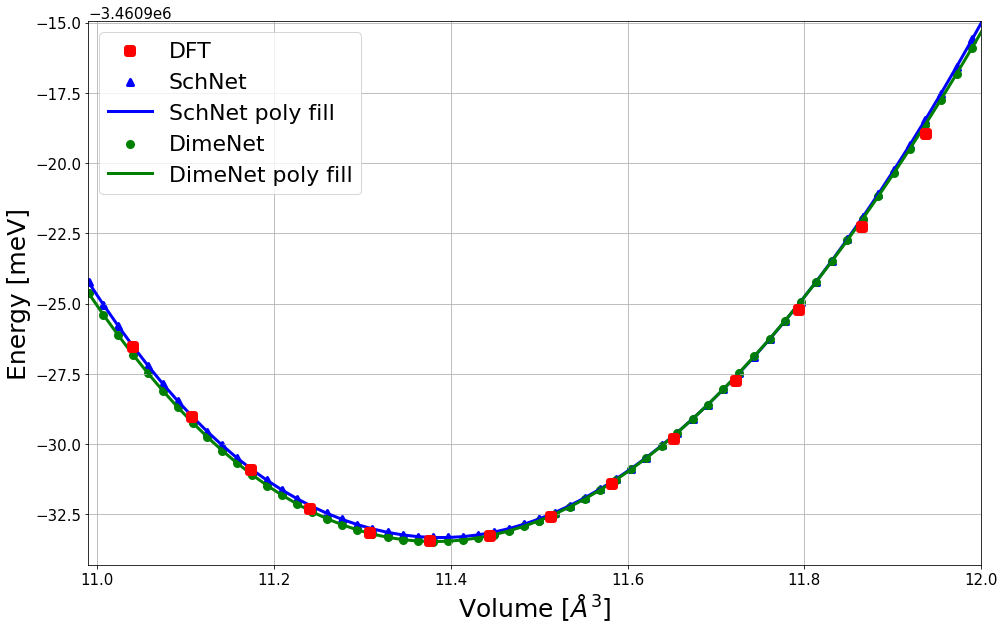

In [ ]:
plt.rcParams.update({'font.size':25})
plt.rcParams.update({'axes.titlesize':30})
plt.rcParams.update({'figure.titlesize':30})
plt.rcParams.update({'xtick.labelsize':15})
plt.rcParams.update({'ytick.labelsize':15})
plt.rcParams.update({'legend.fontsize':22})

fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_xlim(10.99, 12)
ax.set_ylim(-3460934.301071031, -3460914.9599393304)
plt.xlabel("Volume $[\AA^3]$")
plt.ylabel("Energy [meV]")

ax.scatter(eos_x_schnet, [(en*1000) for en in eos_y_schnet], marker="^", color="blue", label="SchNet", linewidth=3)
ax.plot(eos_x_schnet, [(en*1000) for en in eos_y_schnet], color="blue", label="SchNet poly fill", linewidth=3)

ax.scatter(eos_x_dimenet, [(en*1000) for en in eos_y_dimenet], color="green", label="DimeNet", linewidth=3)
ax.plot(eos_x_dimenet, [(en*1000) for en in eos_y_dimenet], color="green", label="DimeNet poly fill", linewidth=3)

ax.scatter(eos_x_dft, eos_y_dft, color="red", label="DFT", marker="s", linewidth=6, zorder=1000)
ax.legend(*([ x[i] for i in [4, 2, 0, 3, 1] ] for x in plt.gca().get_legend_handles_labels()), handletextpad=0.75, loc='best')

plt.grid()
#ax.legend()
plt.show()

In [ ]:
bain_x_schnet, bain_y_schnet, _, _, _ = volume_optimization(model)
bain_x_dimenet, bain_y_dimenet, _, _, _ = volume_optimization(dimenet)

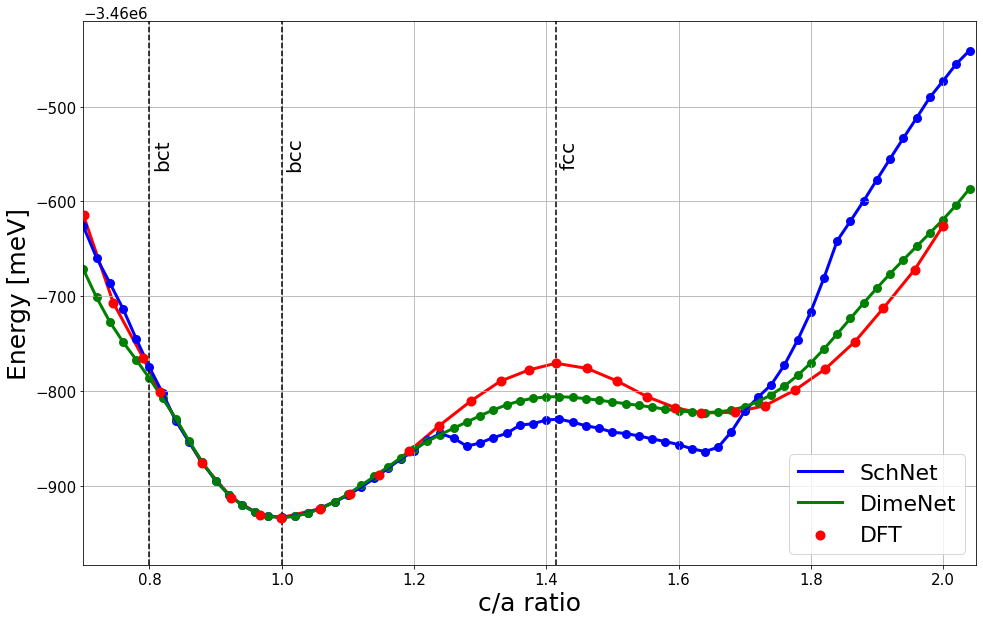

In [ ]:
plt.rcParams.update({'font.size':25})
plt.rcParams.update({'axes.titlesize':30})
plt.rcParams.update({'figure.titlesize':30})
plt.rcParams.update({'xtick.labelsize':15})
plt.rcParams.update({'ytick.labelsize':15})
plt.rcParams.update({'legend.fontsize':22})

fig, ax = plt.subplots(figsize=(16,10))
plt.cla()
ax.set_xlim(0.7, 2.05)
#ax.set_xlim(0.97,1.03)
#ax.set_ylim(-3.461e6, -3.4605e6)
ax.set_ylim(min([y*1000 for y in bain_y_schnet]) -50, -3.4605e6 + 90)
#ax.set_ylim(-3.461e6, -3.4608e6)
#ax.set_title(model_name)
plt.xlabel("c/a ratio")
plt.ylabel("Energy [meV]")

plt.axvline(x=0.8, linestyle='--', color="black")
plt.axvline(x=1.0, linestyle='--', color="black")
plt.axvline(x=math.sqrt(2), linestyle='--', color="black")

ax.scatter(bain_x_schnet, [(en*1000) for en in bain_y_schnet], color="blue", linewidth=3)
ax.plot(bain_x_schnet, [(en*1000) for en in bain_y_schnet], color="blue", label="SchNet", linewidth=3)

ax.scatter(bain_x_dimenet, [(en*1000) for en in bain_y_dimenet], color="green", linewidth=3)
ax.plot(bain_x_dimenet, [(en*1000) for en in bain_y_dimenet], color="green", label="DimeNet", linewidth=3)

ax.scatter(dft_x, [en for en in dft_y], color="red", label="DFT", linewidth=4, zorder=1000)
ax.plot(dft_x, [en for en in dft_y], color="red", linewidth=3, zorder=-1)

plt.text(0.8 + 0.005, -3.46e6 - 550, "bct", rotation=90, verticalalignment='center', size=20)
plt.text(1.0 + 0.005, -3.46e6 - 550, "bcc", rotation=90, verticalalignment='center', size=20)
plt.text(math.sqrt(2) + 0.0059, -3.46e6 - 550, "fcc", rotation=90, verticalalignment='center', size=20)

#ax.scatter(sch_x_cv, [(en*1000) for en in sch_y_cv], color="red")
#ax.plot(sch_x_cv, [(en*1000) for en in sch_y_cv], color="red", label="SchNet Constant Vol.")

ax.grid()
ax.legend(loc=4)